In [1]:
import numpy as np
import scipy as scp
import sigpy as sp
import sigpy.mri as mr
import sigpy.plot as pl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import os
import time

# custom convenience functions
from utils.plotting import mid3views

# Set-up plots
plt.rcParams['figure.figsize'] = [12.8, 9.6] # make figures twice as large as default size
plt.rcParams['figure.dpi'] = 200 # make figures twice as high dpi

# GPU choice
gpu_id = 3

/home/rexfung/github/sigpy-mri-tutorial/.venv/lib/python3.10/site-packages/sigpy/config.py:27: UserWarning: Importing cupy.cuda.cudnn failed. For more details, see the error stack below:
No module named 'cupyx.cudnn'
  warnings.warn(


In [2]:
# Load some data
dataType = '3D'
fn_2d = '/mnt/storage/rexfung/greTestData/gre_2d.mat'
fn_3d = '/mnt/storage/rexfung/greTestData/gre_3d.mat'

if dataType == '2D':
    ksp = scp.io.loadmat(fn_2d)['ksp'] # coil, ky, kx
    Ncoils, Ny, Nx = ksp.shape # convenience vars

elif dataType == '3D':
    ksp = scp.io.loadmat(fn_3d)['ksp'] # coil, kz, ky, kx
    Ncoils, Nz, Ny, Nx = ksp.shape # convenience vars

# Retrospectively 6x undersample data with CAIPI pattern
if dataType == '2D':
    mask = np.zeros([Ny, Nx]); # ky, kx for 2D
    Rx = 3
    Ry = 3
    for shift_y in range(Ry):
        mask[shift_y:None:Ry,shift_y*Rx:None:Rx*Ry] = 1
if dataType == '3D':
    mask = np.zeros([Nz, Ny, Nx]) # kz, ky, kx for 3D
    Ry = 3
    Rz = 3
    for shift_z in range(Rz):
        mask[shift_z:None:Rz,shift_z*Ry:None:Ry*Rz,:] = 1
ksp_us = mask * ksp
print('Sampling rate: ', np.sum(mask)/np.size(mask))

Sampling rate:  0.1134


In [3]:
ksp.dtype

dtype('complex64')

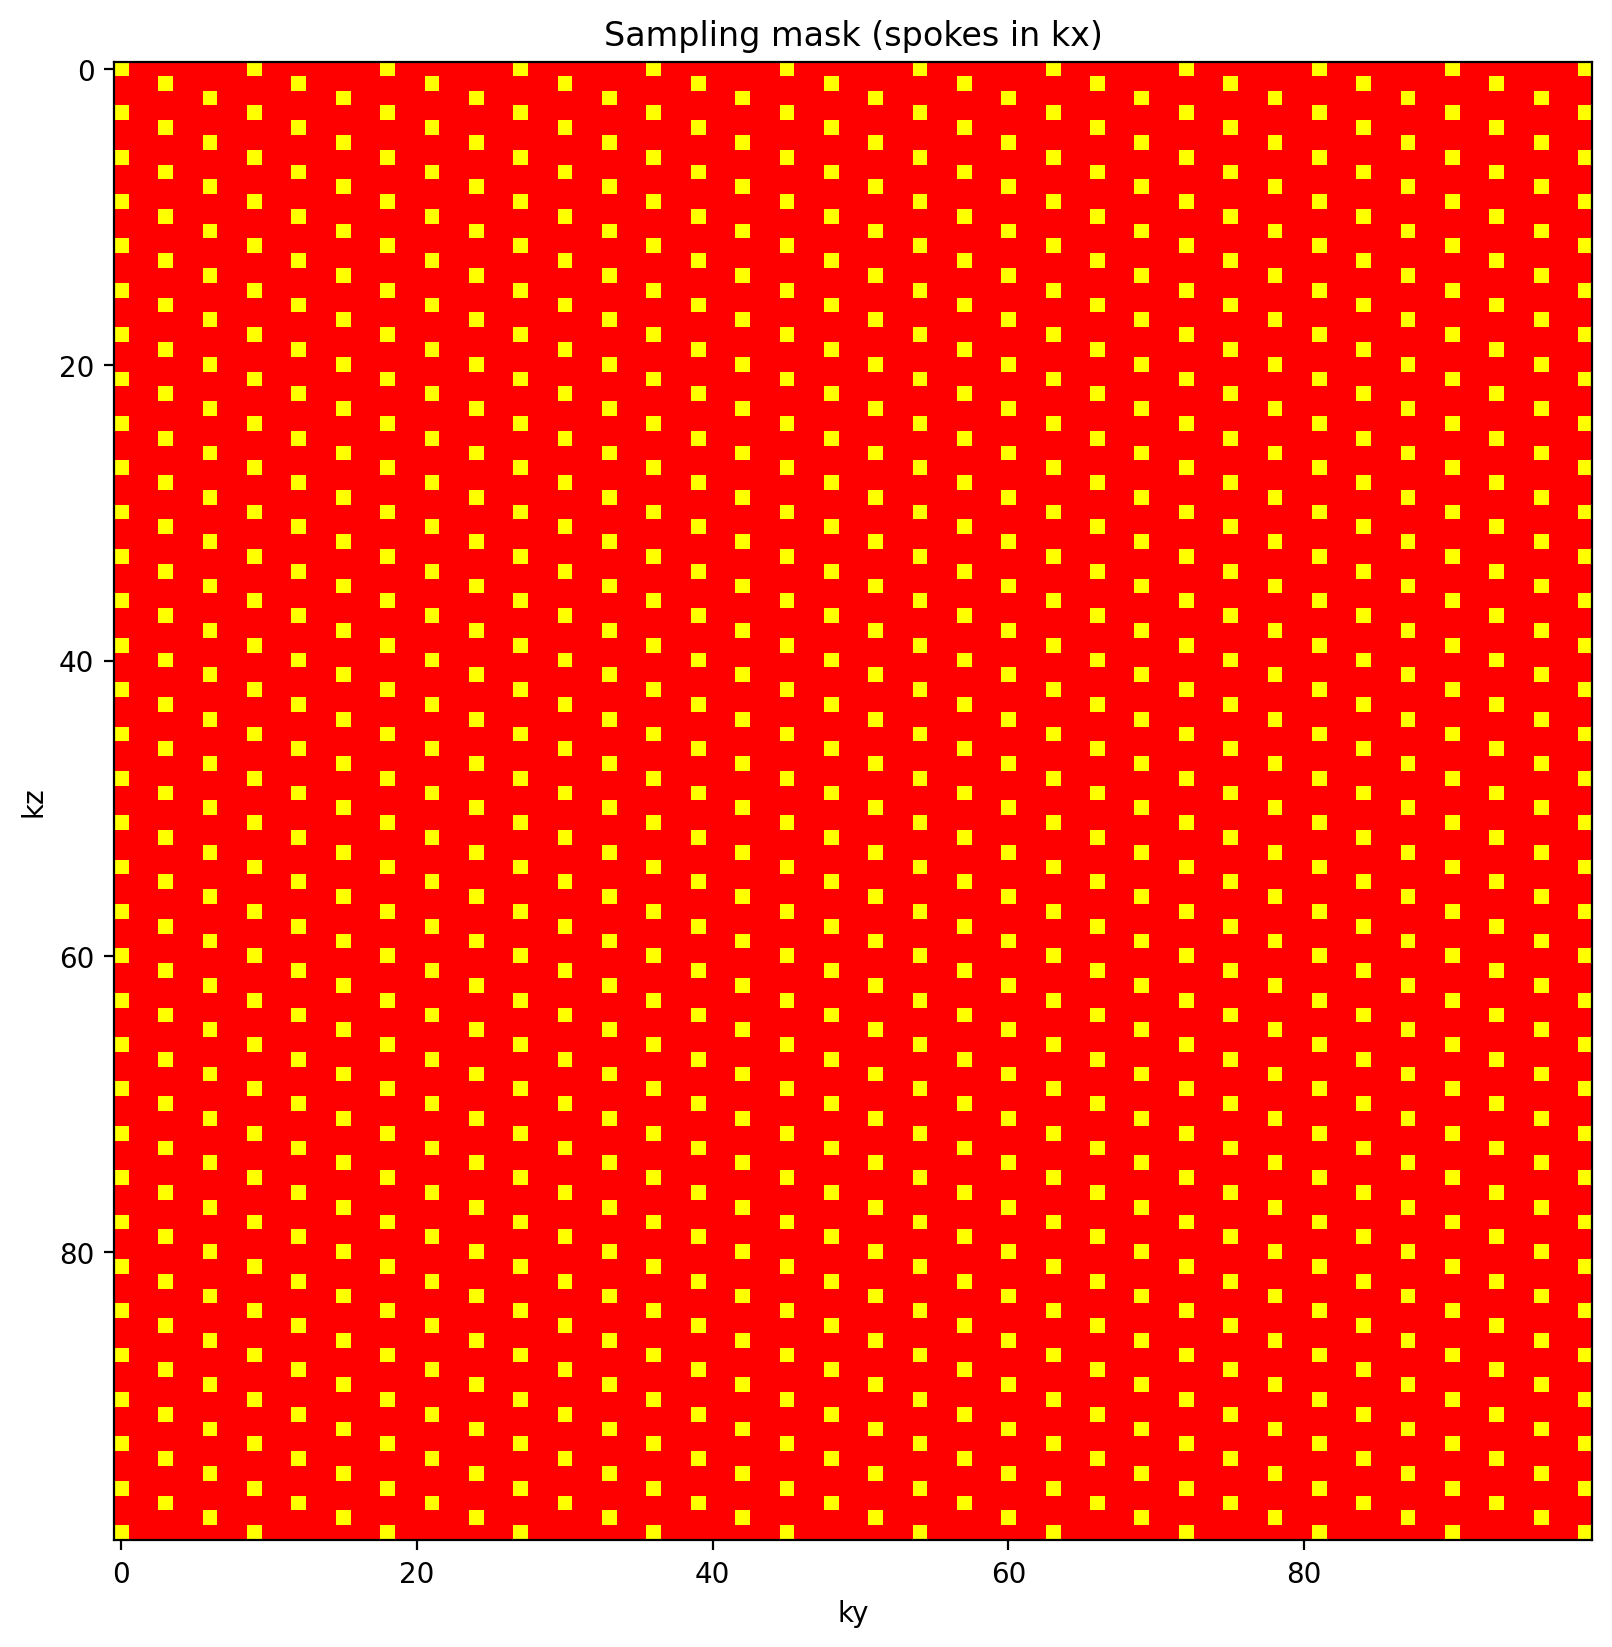

In [4]:
if dataType == '2D':
    plt.figure()
    plt.imshow(mask, cmap='autumn')
    plt.title('Sampling mask')
    plt.xlabel('kx')
    plt.ylabel('ky')
elif dataType == '3D':
    plt.figure()
    plt.imshow(mask[:,:,0], cmap='autumn')
    plt.title('Sampling mask (spokes in kx)')
    plt.xlabel('ky')
    plt.ylabel('kz')

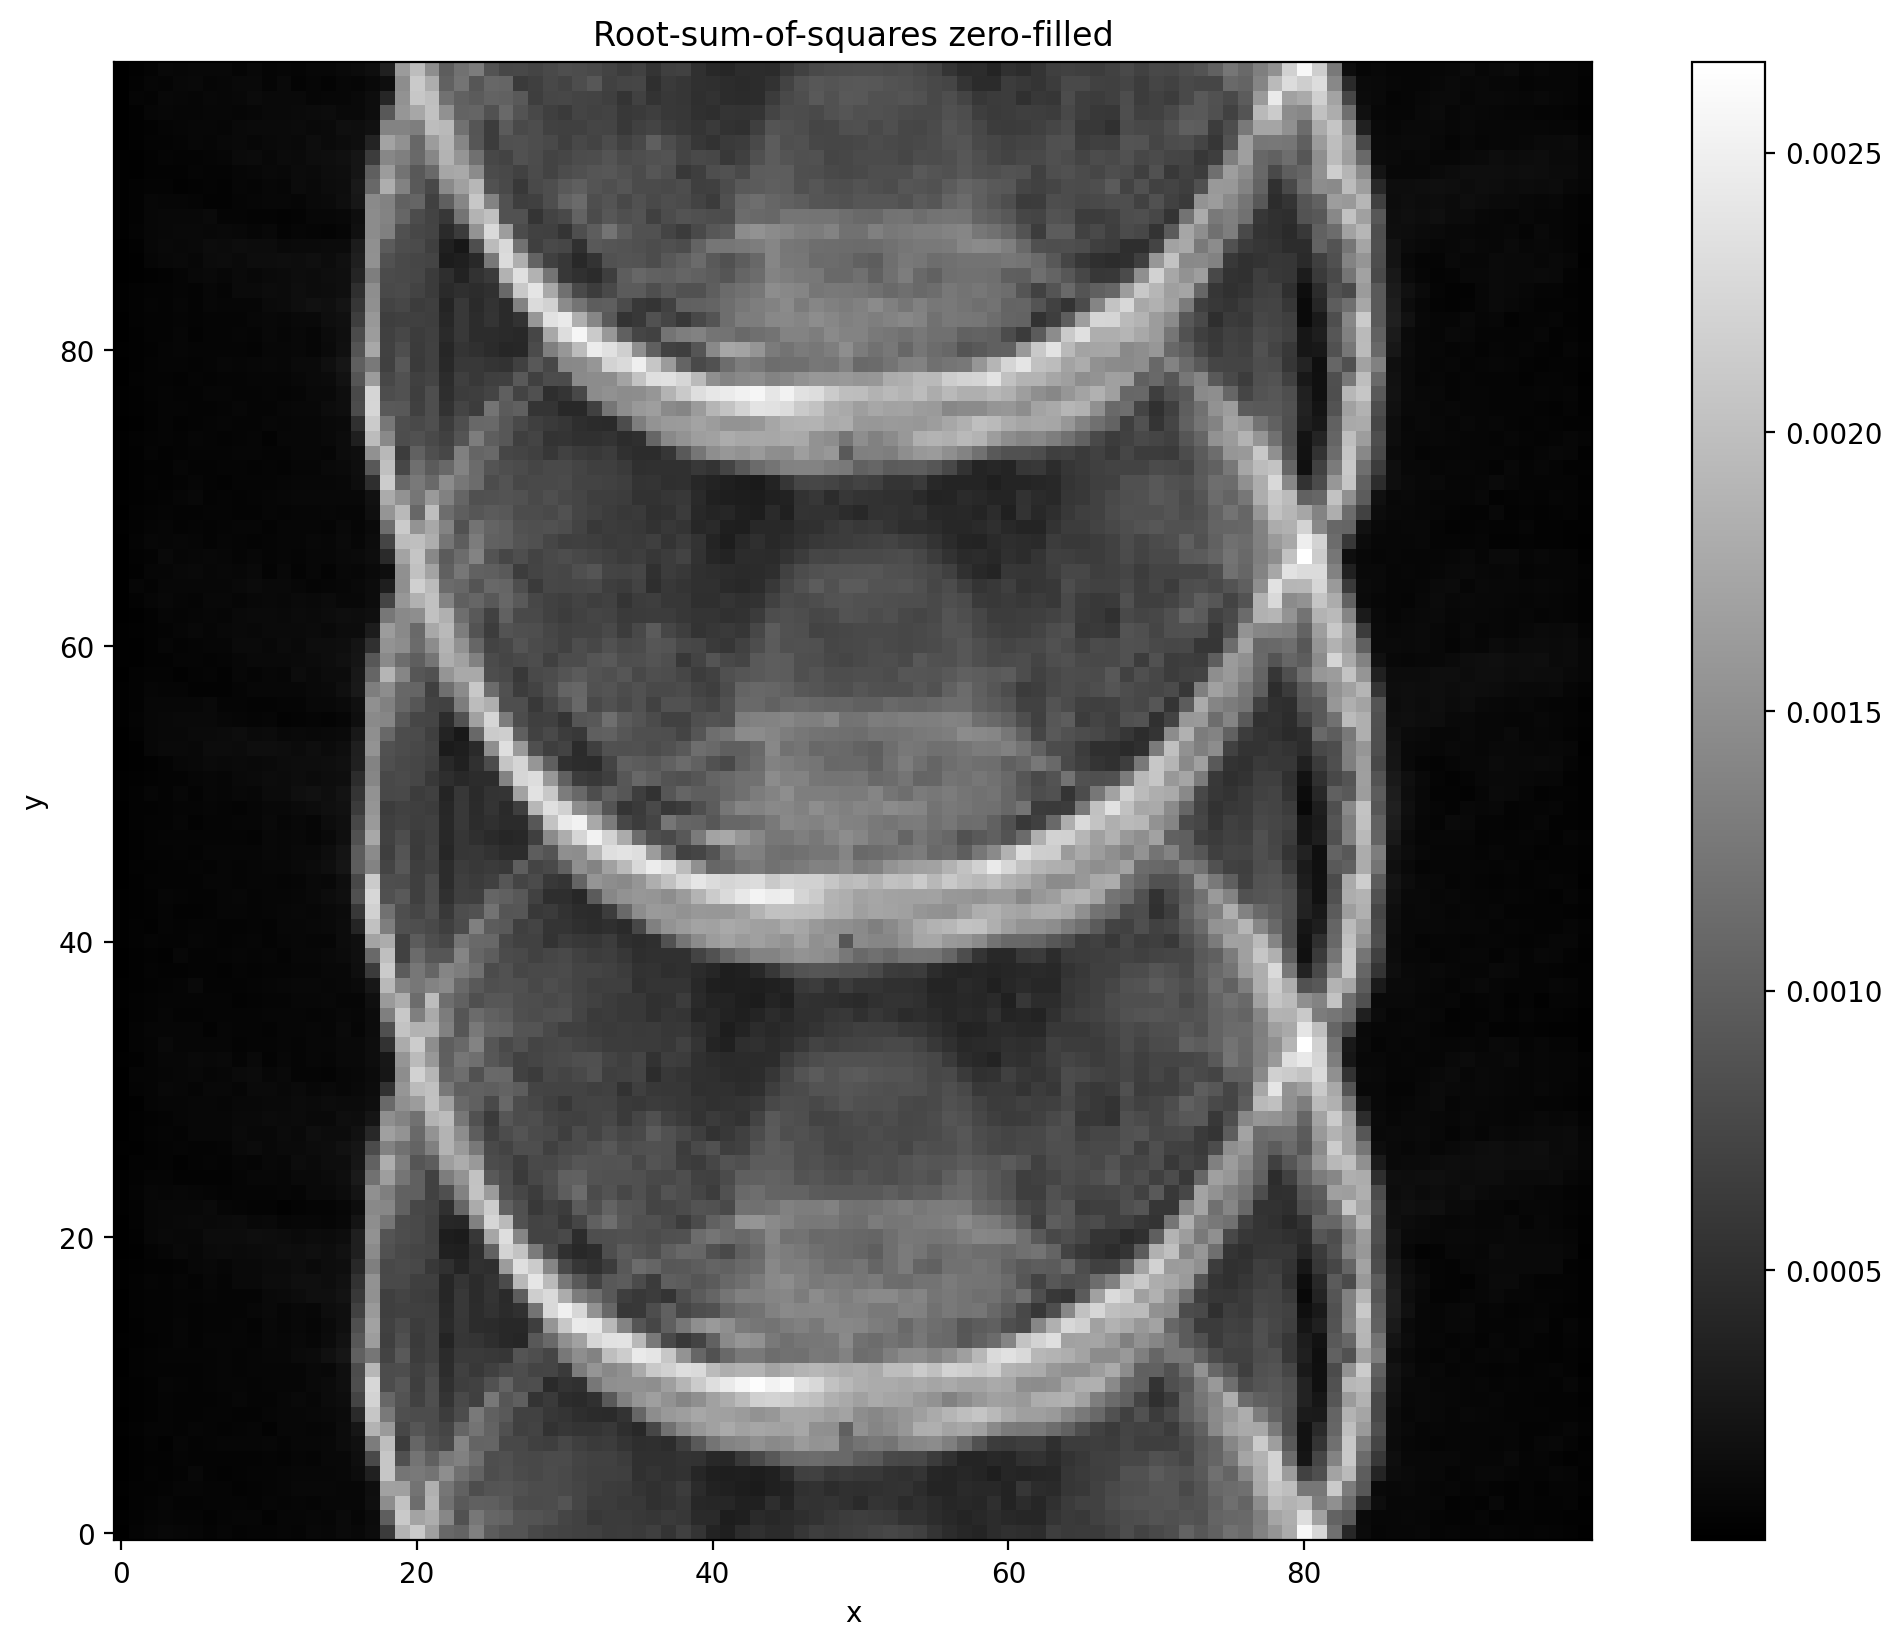

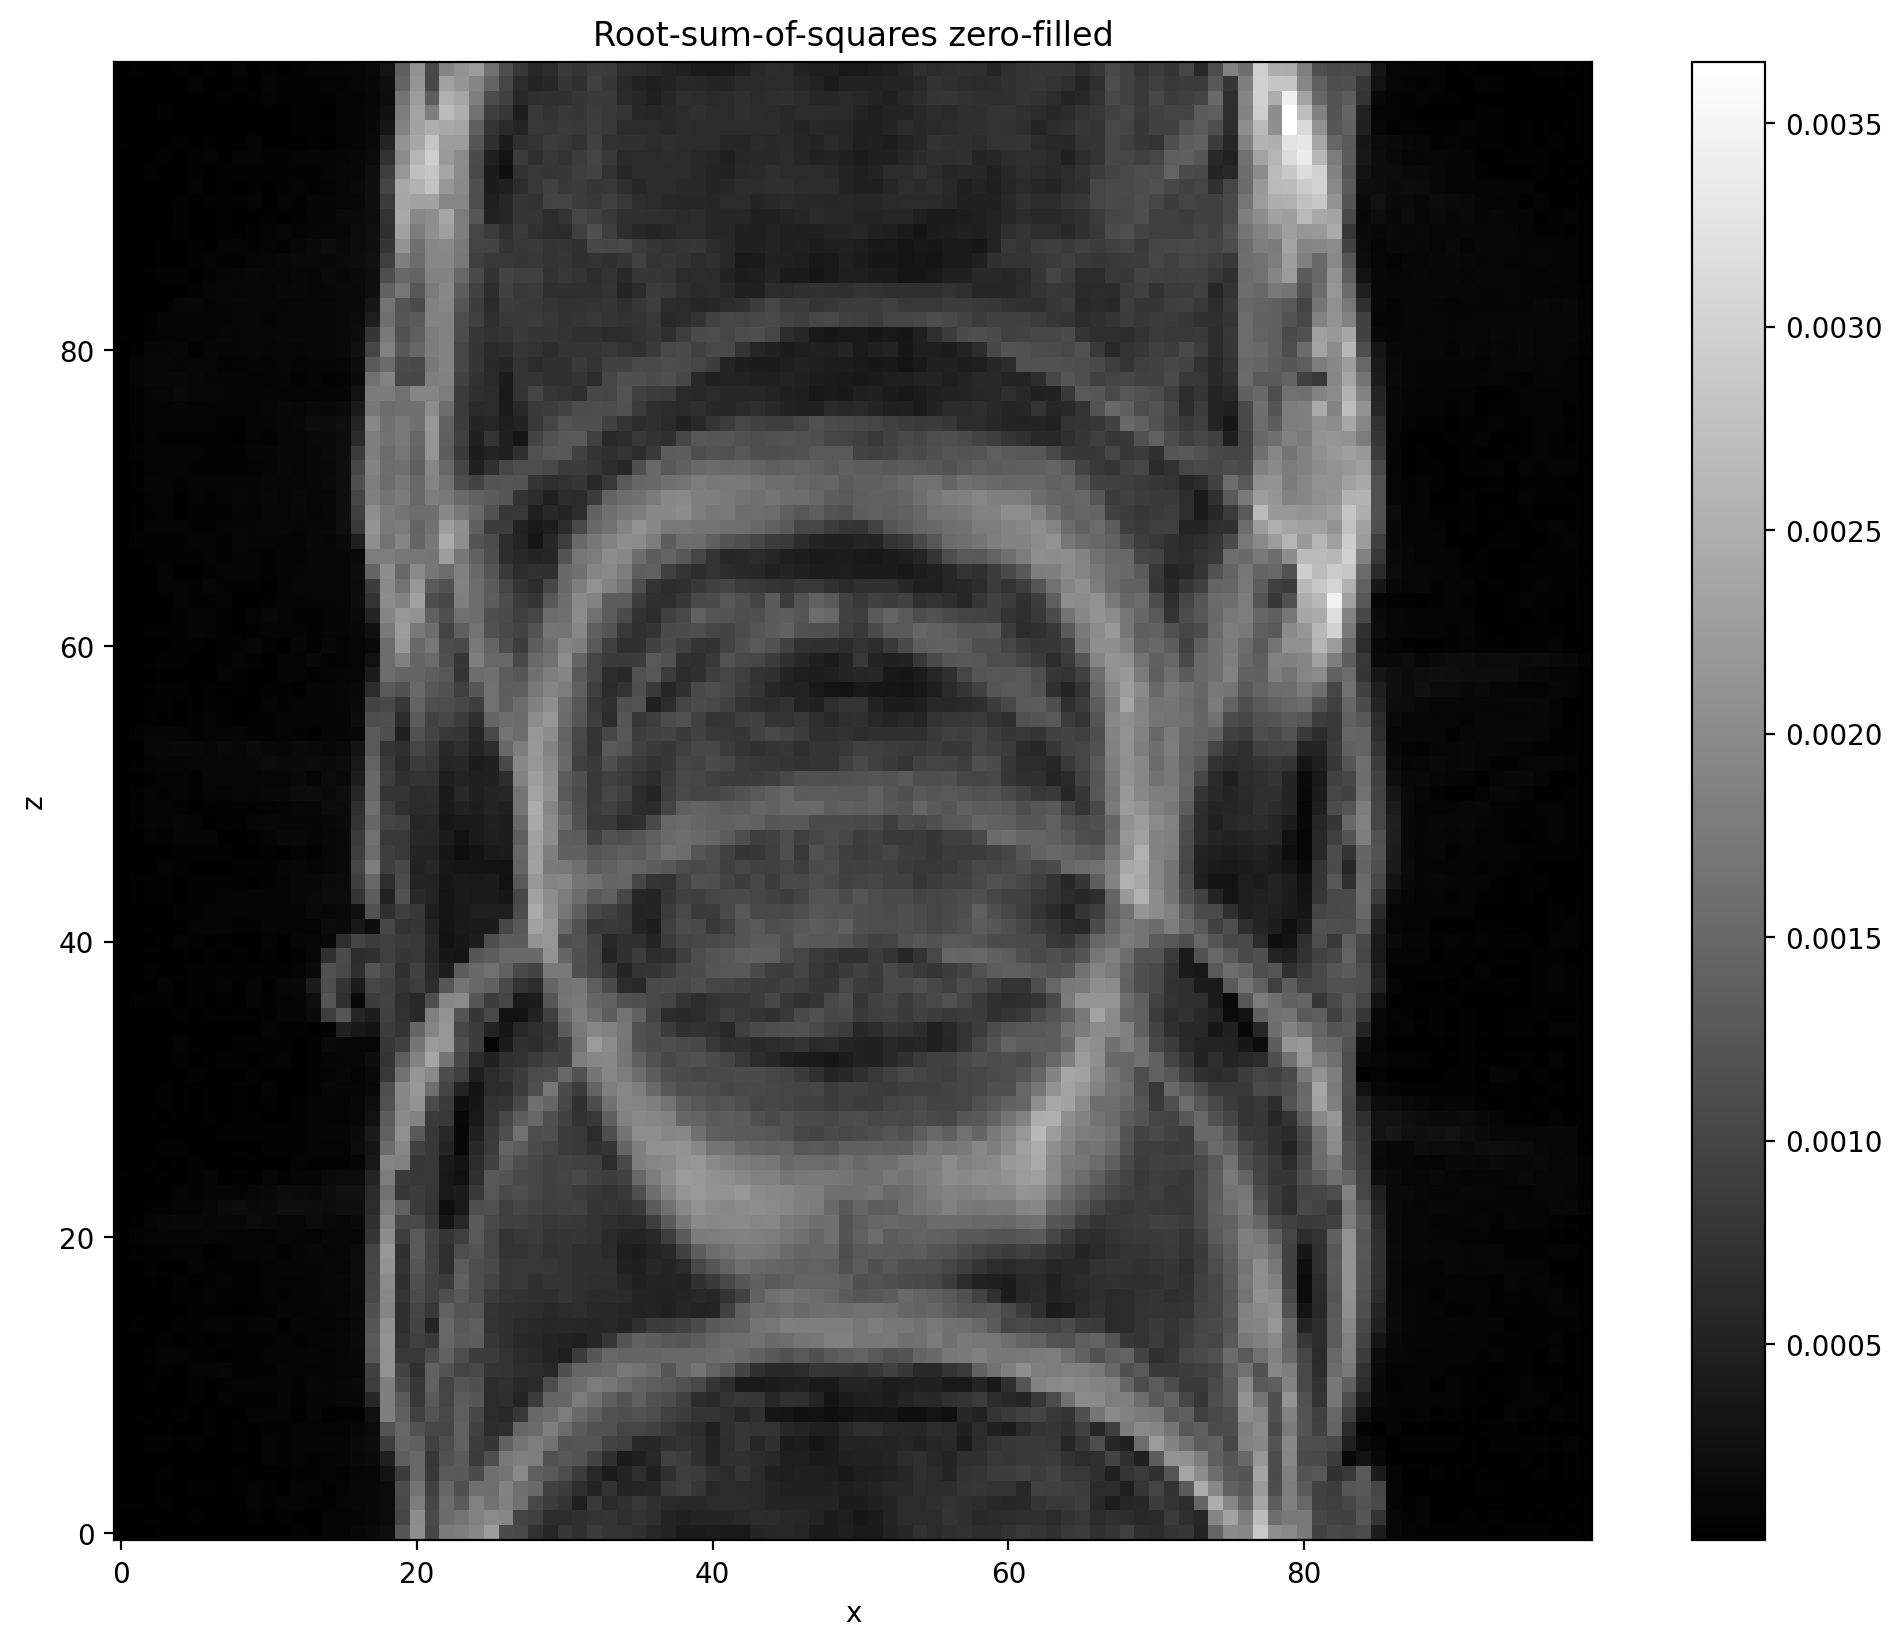

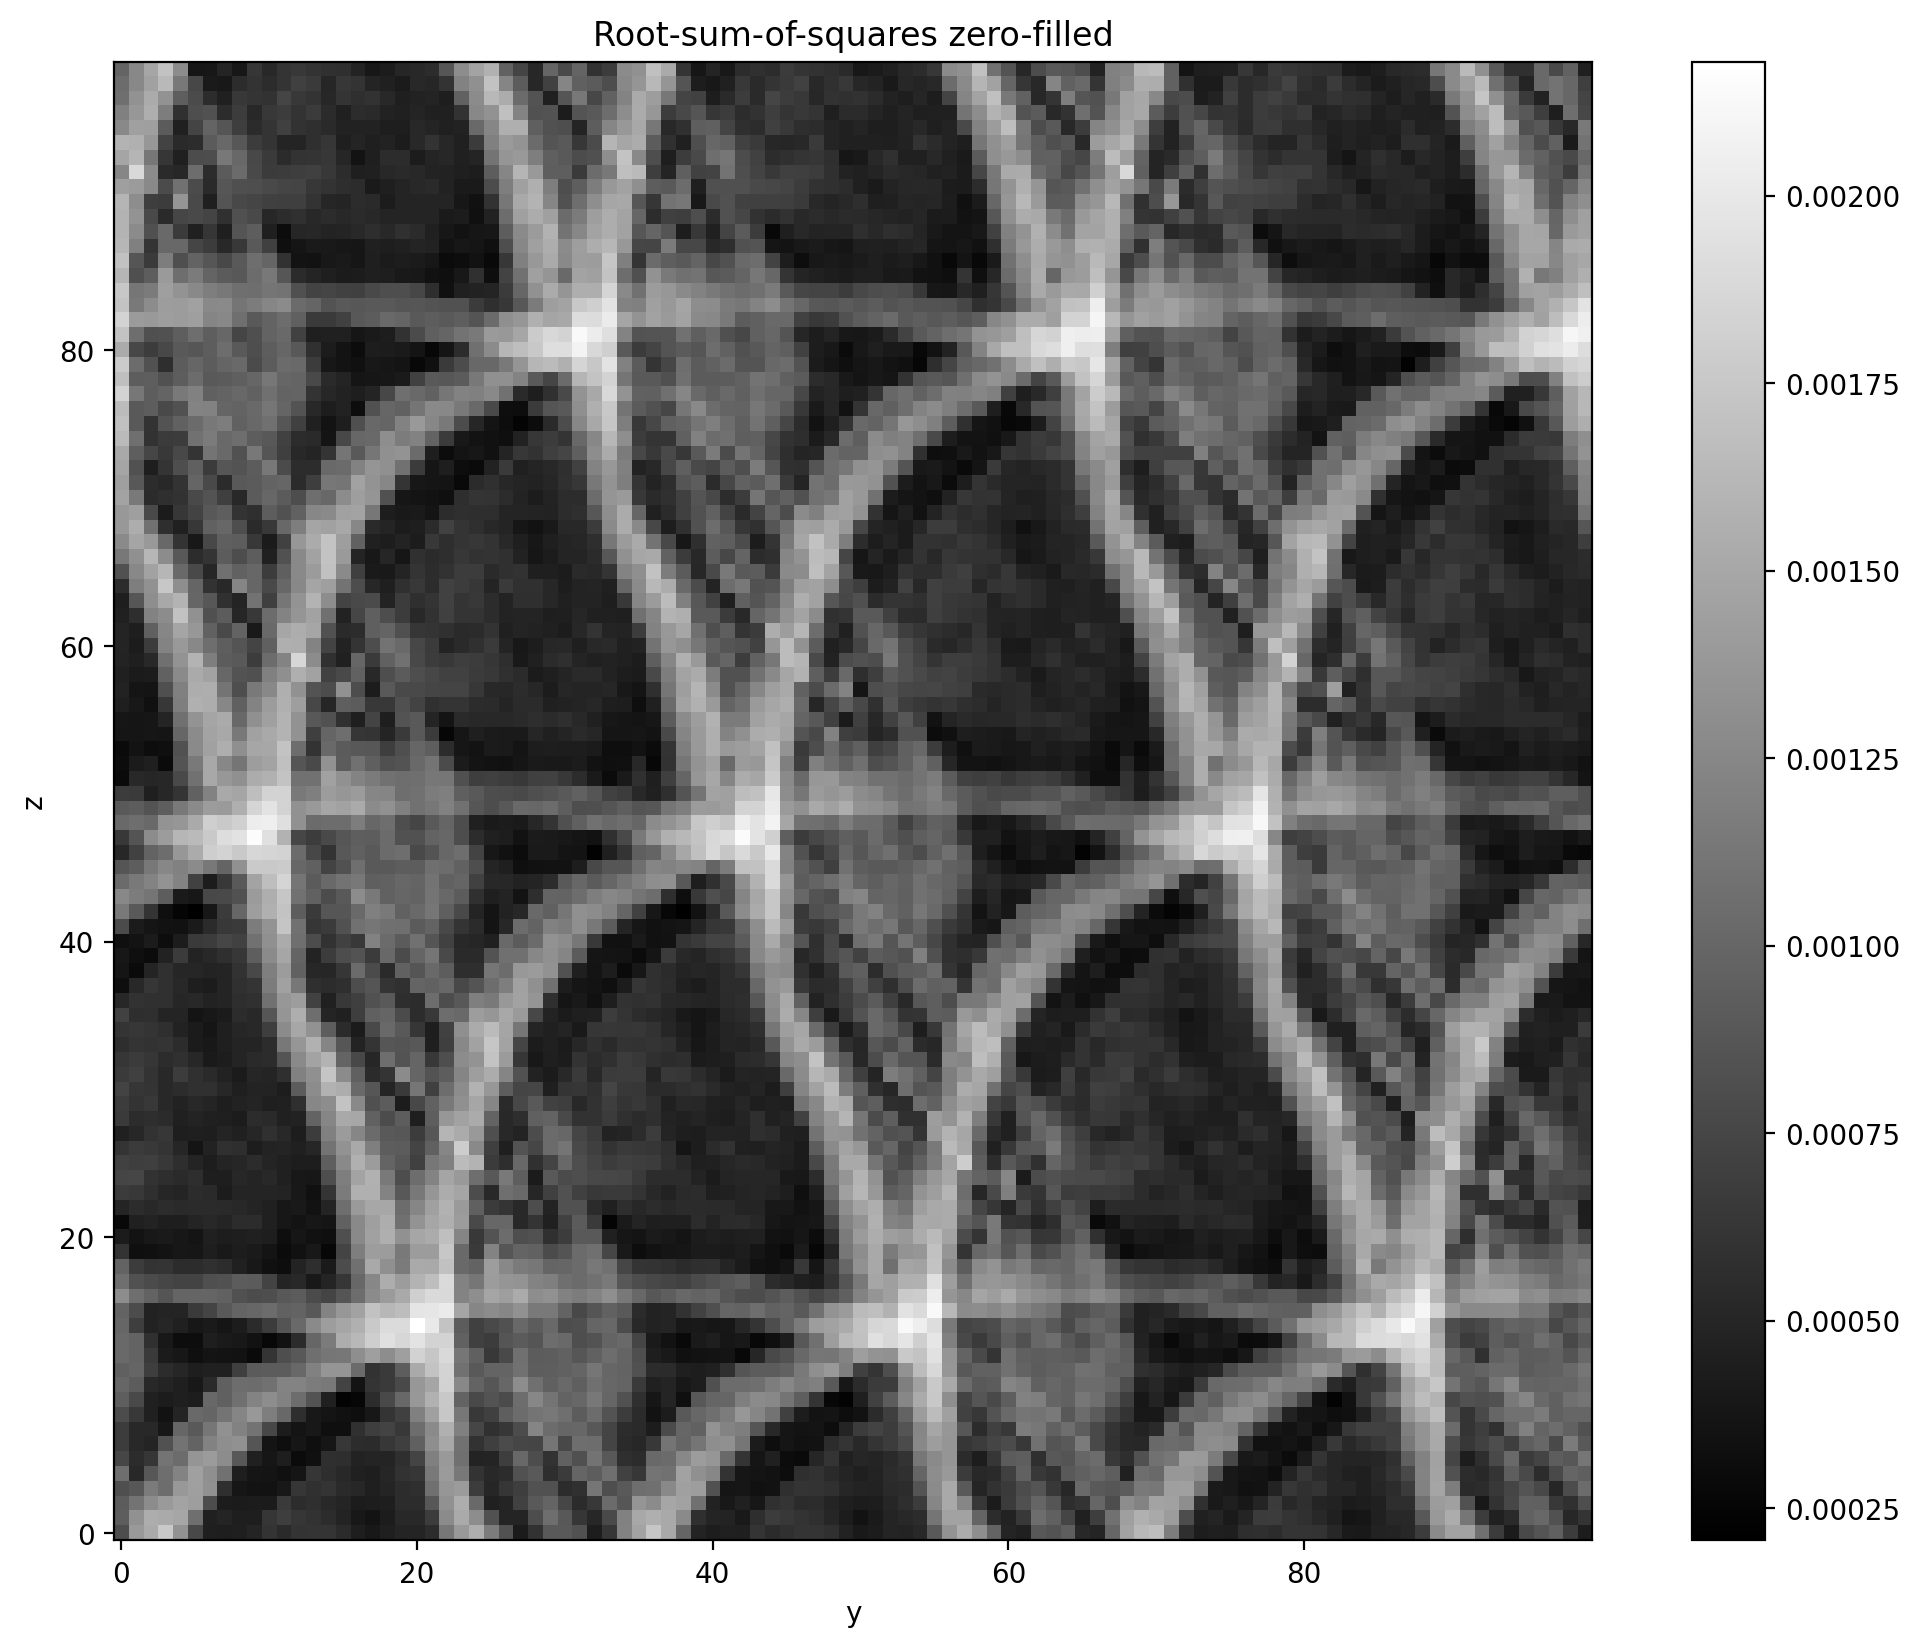

In [5]:
# Show aliasing from undersampled data
img_rss = np.sum(np.abs(sp.ifft(ksp_us, axes=(1, 2, 3)))**2, axis=0)**0.5
img_rss /= np.linalg.norm(img_rss)

if dataType == '2D':
    plt.figure()
    plt.imshow(img_rss, cmap='gray', origin='lower')
    plt.title('Root-sum-of-squares Zero-filled')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()
elif dataType == '3D': # show the middle 3 views of the image
    mid3views(img_rss, 'Root-sum-of-squares zero-filled')

Time elapsed: 16.788528442382812


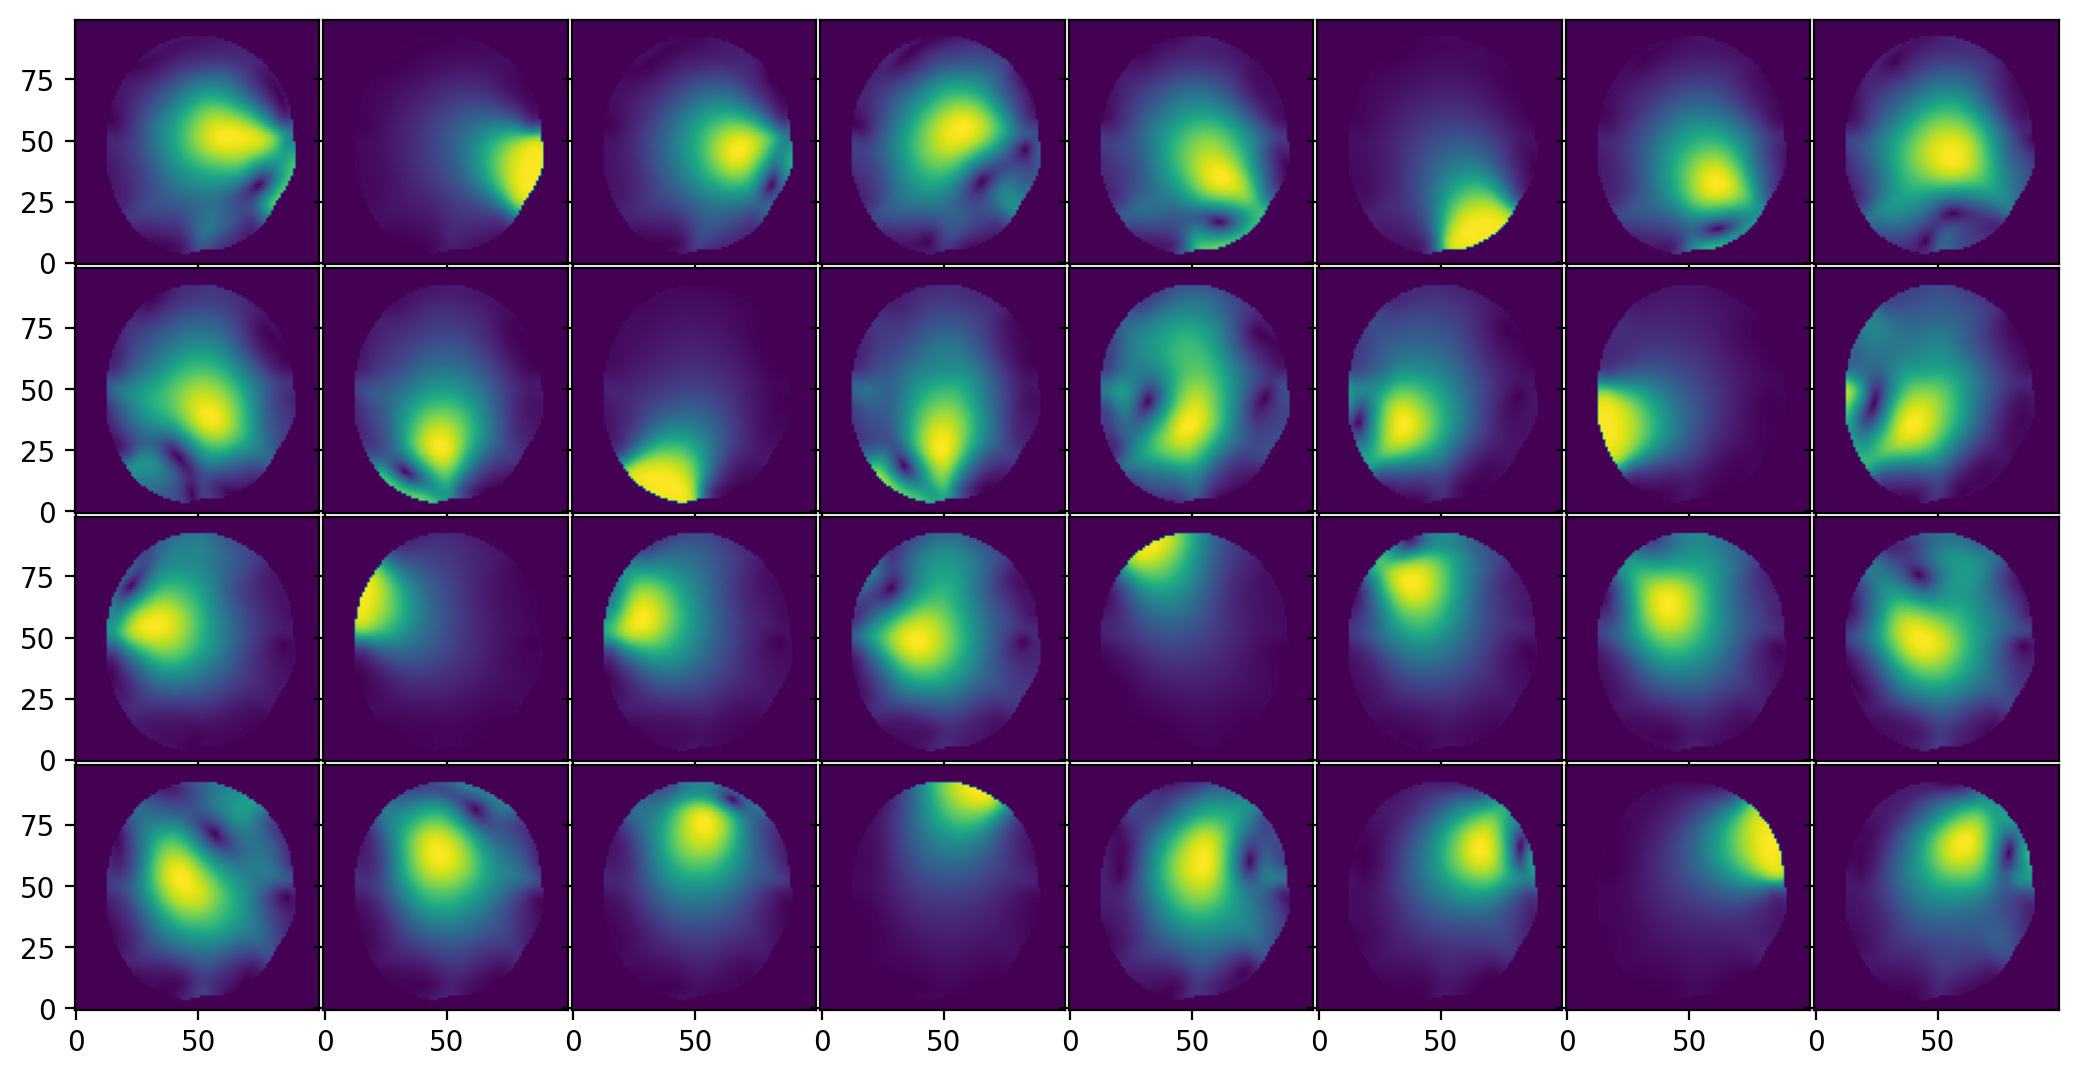

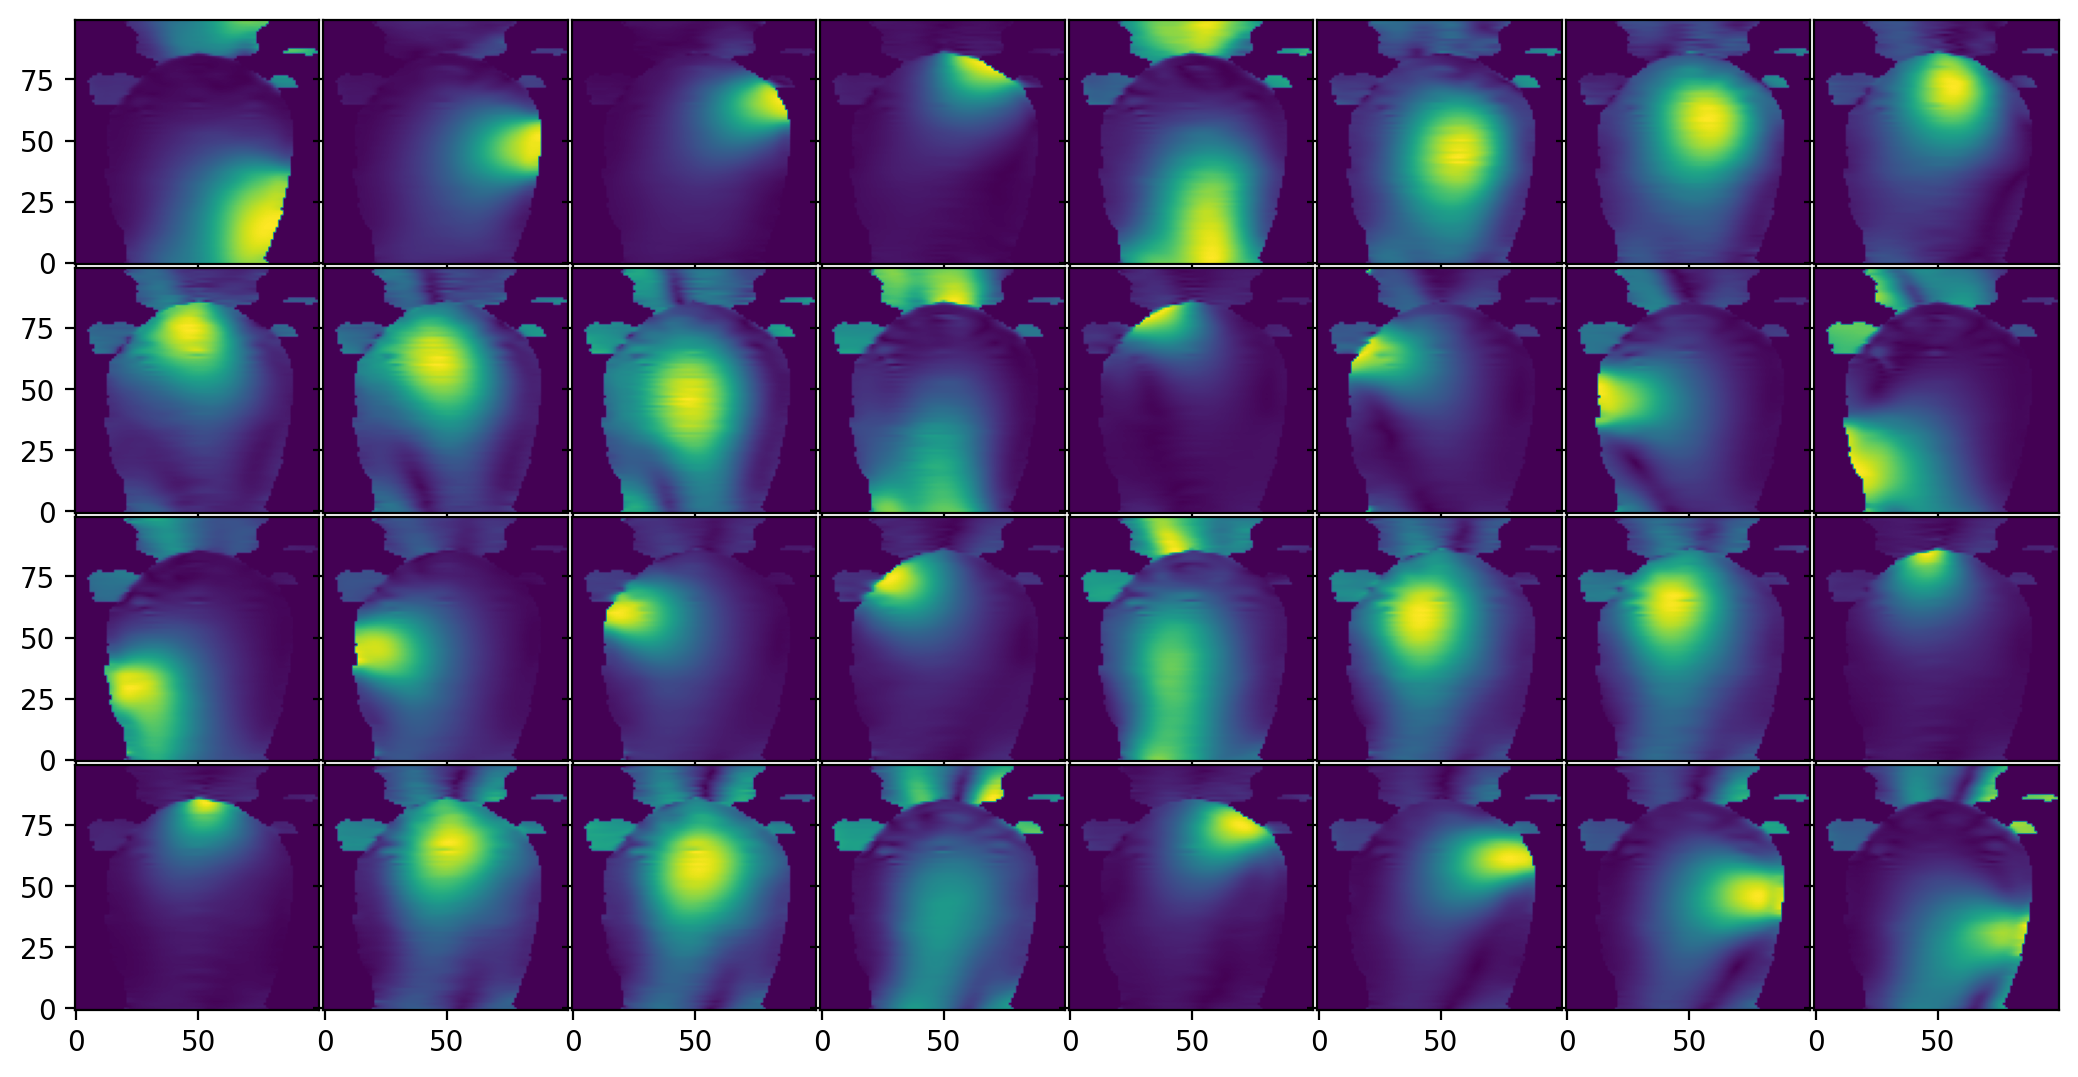

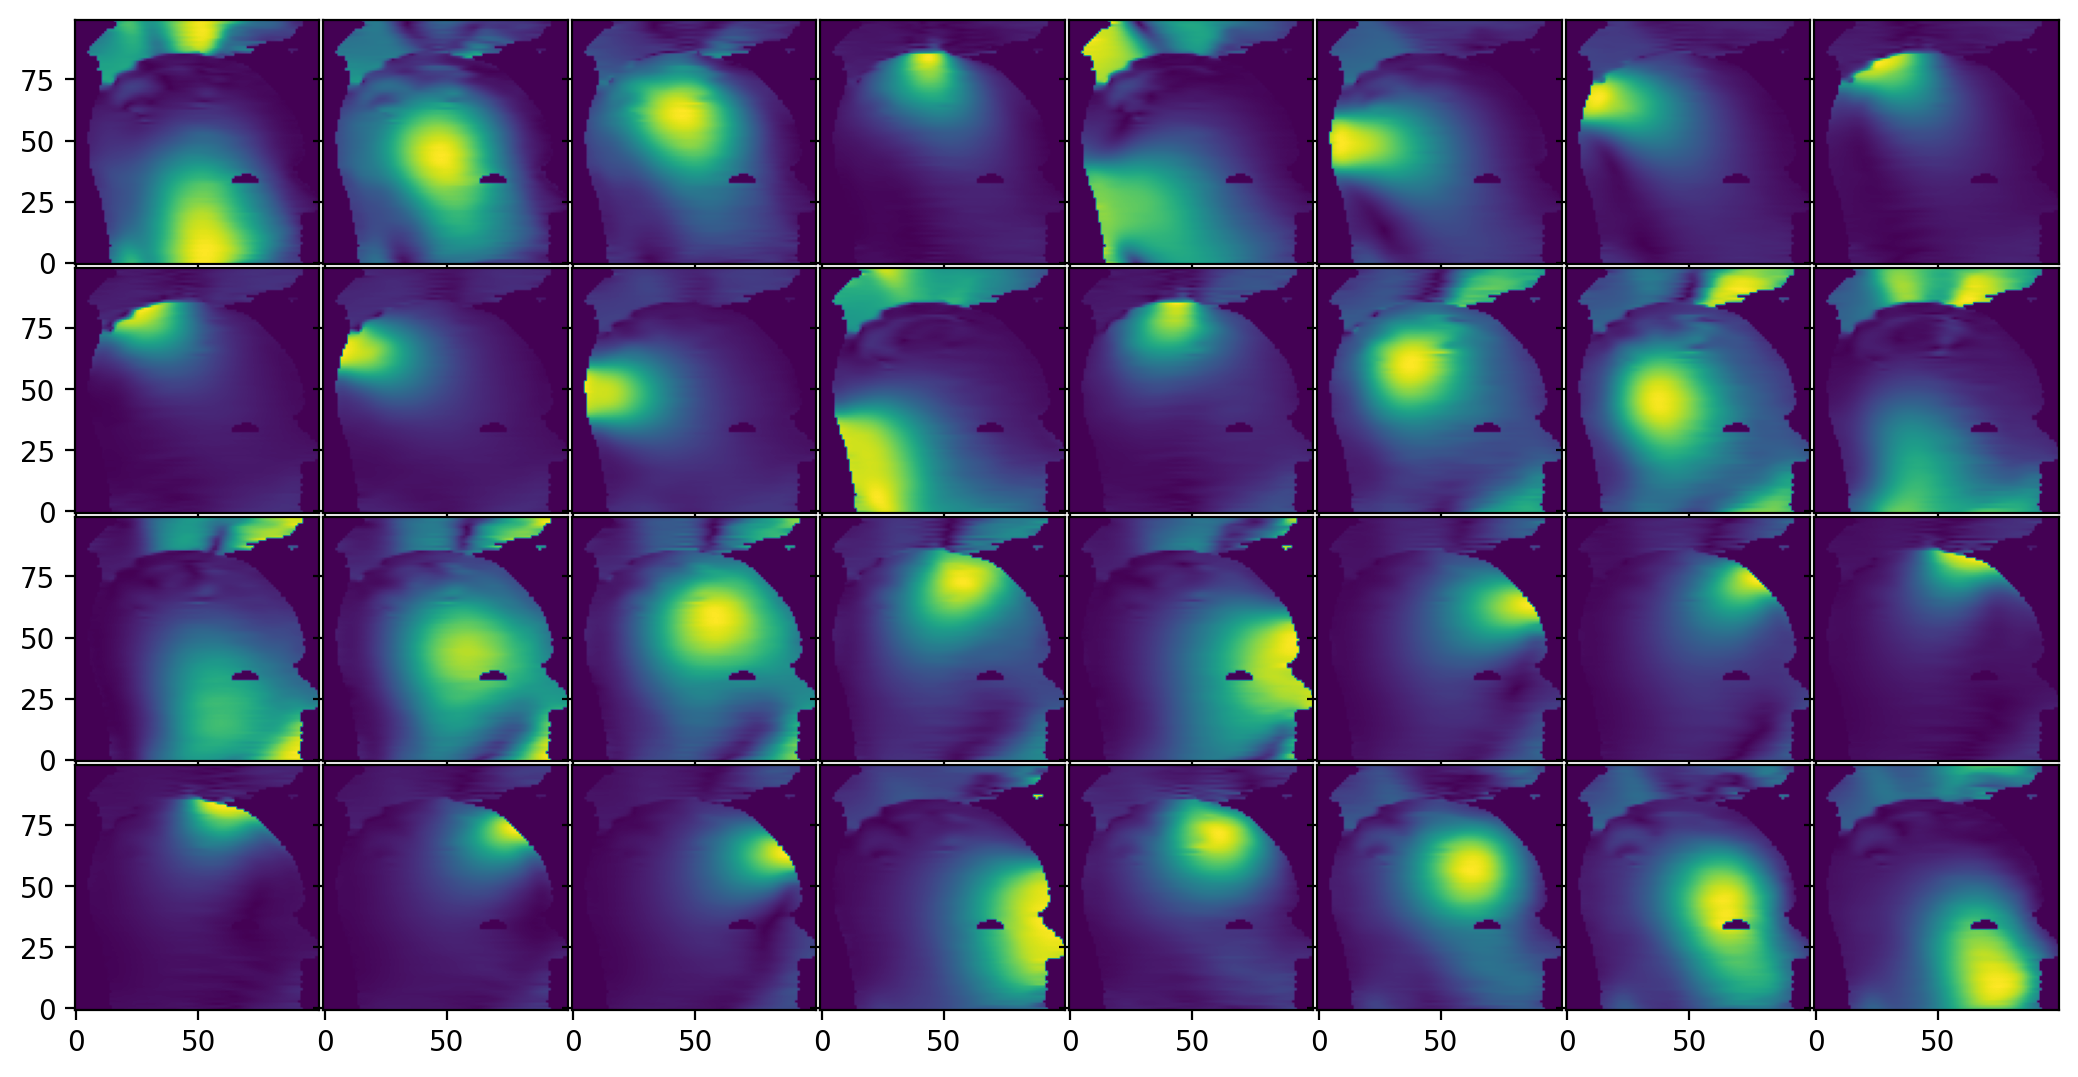

In [6]:
# Estimate sensitivity maps
fn_mps_3d = '/mnt/storage/rexfung/greTestData/gre_3d_mps.mat'

if dataType == '2D':
    mps = mr.app.EspiritCalib(ksp).run()
elif dataType == '3D':
    # create smaps if not present (takes a while)
        start = time.time()

        # Compute smaps per slice in all 3 directions, then average
        mps_z = np.zeros_like(ksp)
        hybrid_ksp = sp.ifft(ksp, axes=(1,)) # coil, z, ky, kx
        for z in range(Nz):
            mps_z[:,z,:,:] = mr.app.EspiritCalib(hybrid_ksp[:,z,:,:],device=gpu_id,show_pbar=False).run().get()

        # mps_y = np.zeros_like(ksp)
        # hybrid_ksp = sp.ifft(ksp, axes=(2,)) # coil, kz, y, kx
        # for y in range(Ny):
        #     mps_y[:,:,y,:] = mr.app.EspiritCalib(hybrid_ksp[:,:,y,:],device=0,show_pbar=False).run().get()

        # mps_x = np.zeros_like(ksp)
        # hybrid_ksp = sp.ifft(ksp, axes=(3,)) # coil, kz, ky, x
        # for x in range(Nx):
        #     mps_x[:,:,:,x] = mr.app.EspiritCalib(hybrid_ksp[:,:,:,x],device=0,show_pbar=False).run().get()
        
        # mps = (mps_z + mps_y + mps_x) / 3
        mps = mps_z
        
        # TRIED:
        # cannot compute smaps all at once due to memory limit
        # appears to require ~18 gigabytes for computing entire smaps at once
        # mps = mr.app.EspiritCalib(ksp, device=1).run().get()
        
        end = time.time()
        print(f"Time elapsed: {end - start}")

        # TRIED:
        # smooth along z since smaps should be smooth. Appears to make the recon worse though...
        # mps = scp.ndimage.uniform_filter1d(mps,size=3,axis=1)

        # save it for next time
        mdic = {'mps': mps}
        scp.io.savemat(fn_mps_3d, mdic)

    # 3D times:
    # Quickstep CPU: 16 m 42 s
    # Quickstep GPU (device=0, 4x RTX 2080 Ti): 14 s / direction

# Display
if dataType == '2D':
    fig = plt.figure()
    grid = ImageGrid(fig,111,nrows_ncols=(4,8))
    for coil in range(Ncoils):
        grid[coil].imshow(np.abs(mps[coil,:,:]),cmap='inferno',origin='lower')
    plt.show()
elif dataType == '3D':
    fig_ax = plt.figure()
    grid_ax = ImageGrid(fig_ax,111,nrows_ncols=(4,8))
    for coil in range(Ncoils):
        grid_ax[coil].imshow(np.abs(mps[coil,mps.shape[1]//2,:,:]),origin='lower')
    plt.show()

    fig_cor = plt.figure()
    grid_cor = ImageGrid(fig_cor,111,nrows_ncols=(4,8))
    for coil in range(Ncoils):
        grid_cor[coil].imshow(np.abs(mps[coil,:,mps.shape[2]//2,:]),origin='lower')
    plt.show()

    fig_sag = plt.figure()
    grid_sag = ImageGrid(fig_sag,111,nrows_ncols=(4,8))
    for coil in range(Ncoils):
        grid_sag[coil].imshow(np.abs(mps[coil,:,:,mps.shape[3]//2]),origin='lower')
    plt.show()

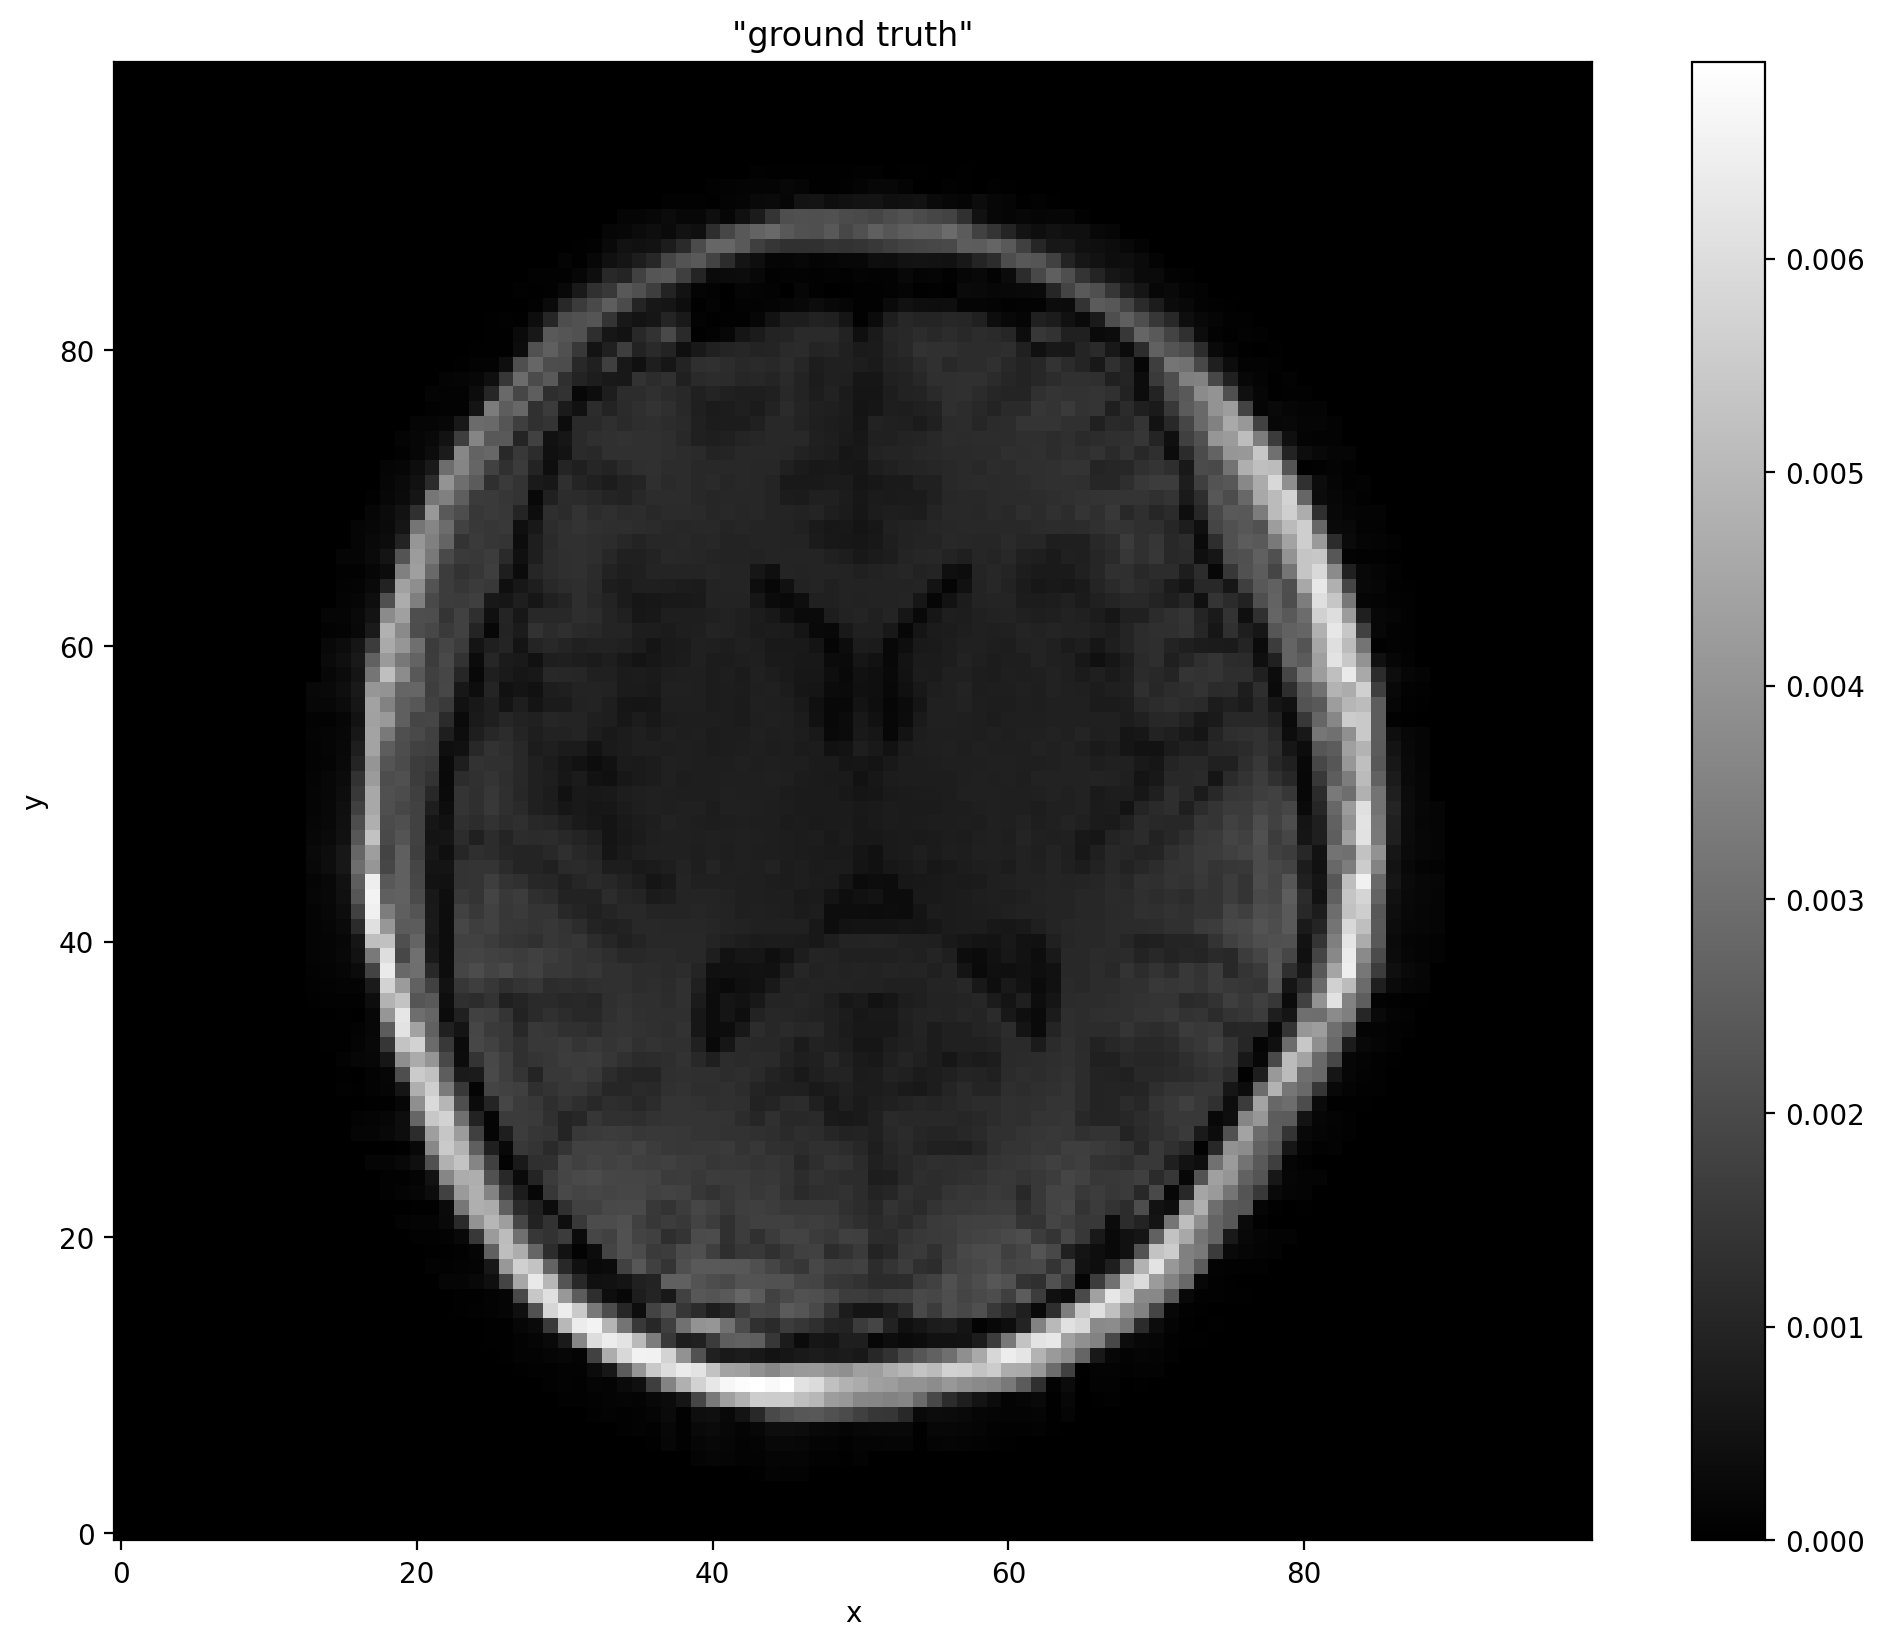

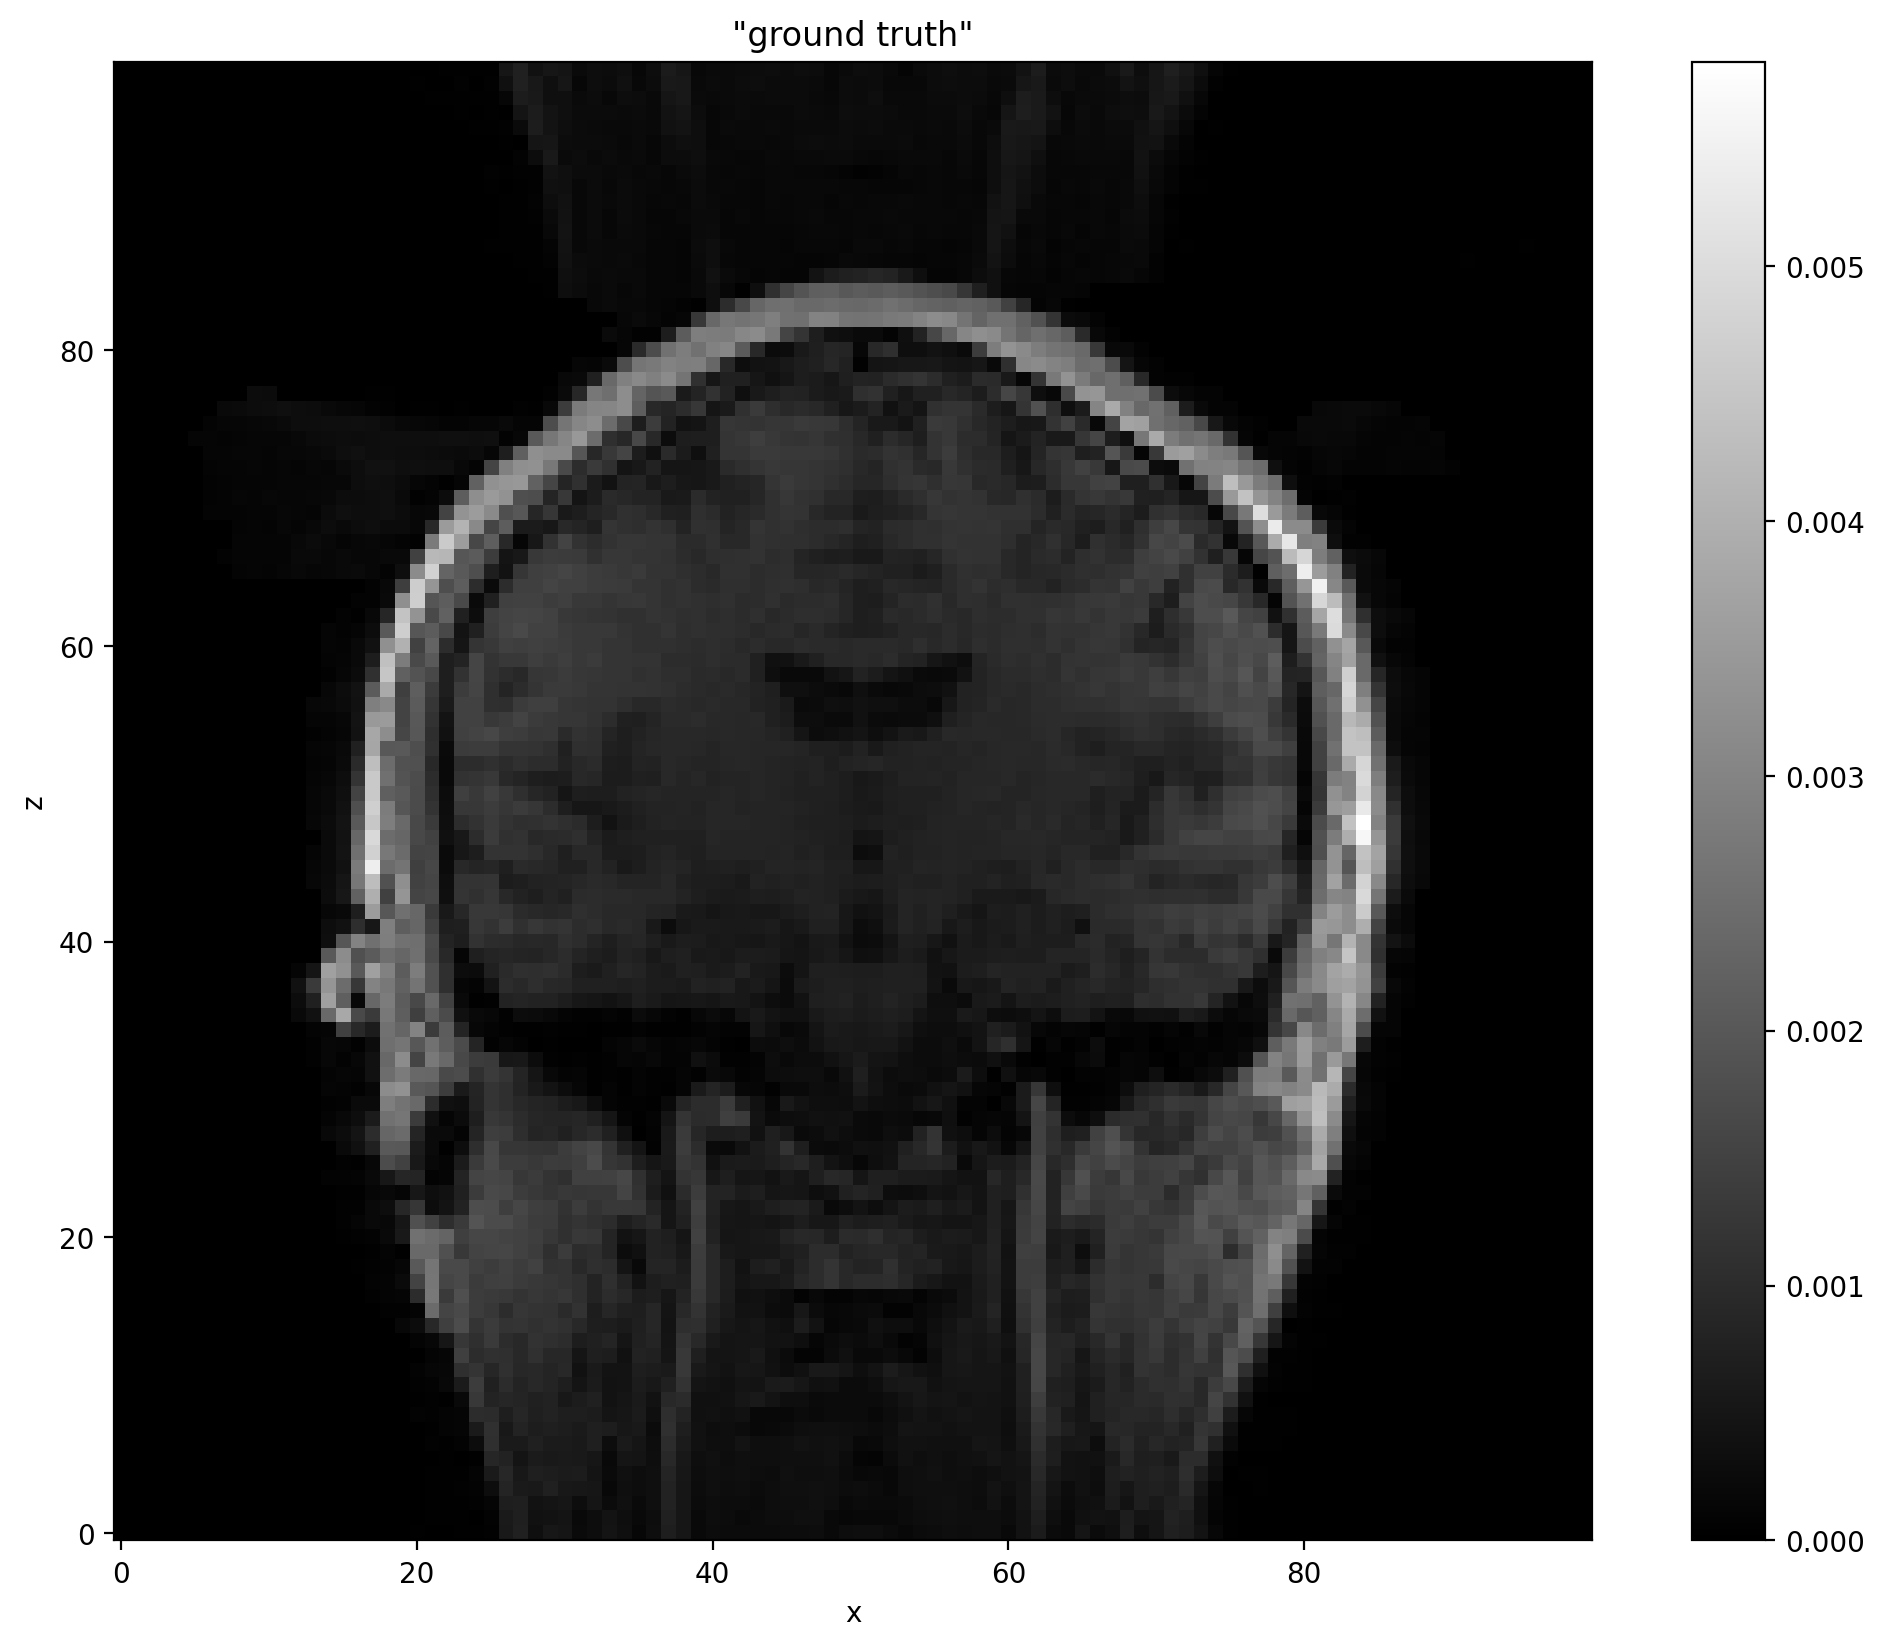

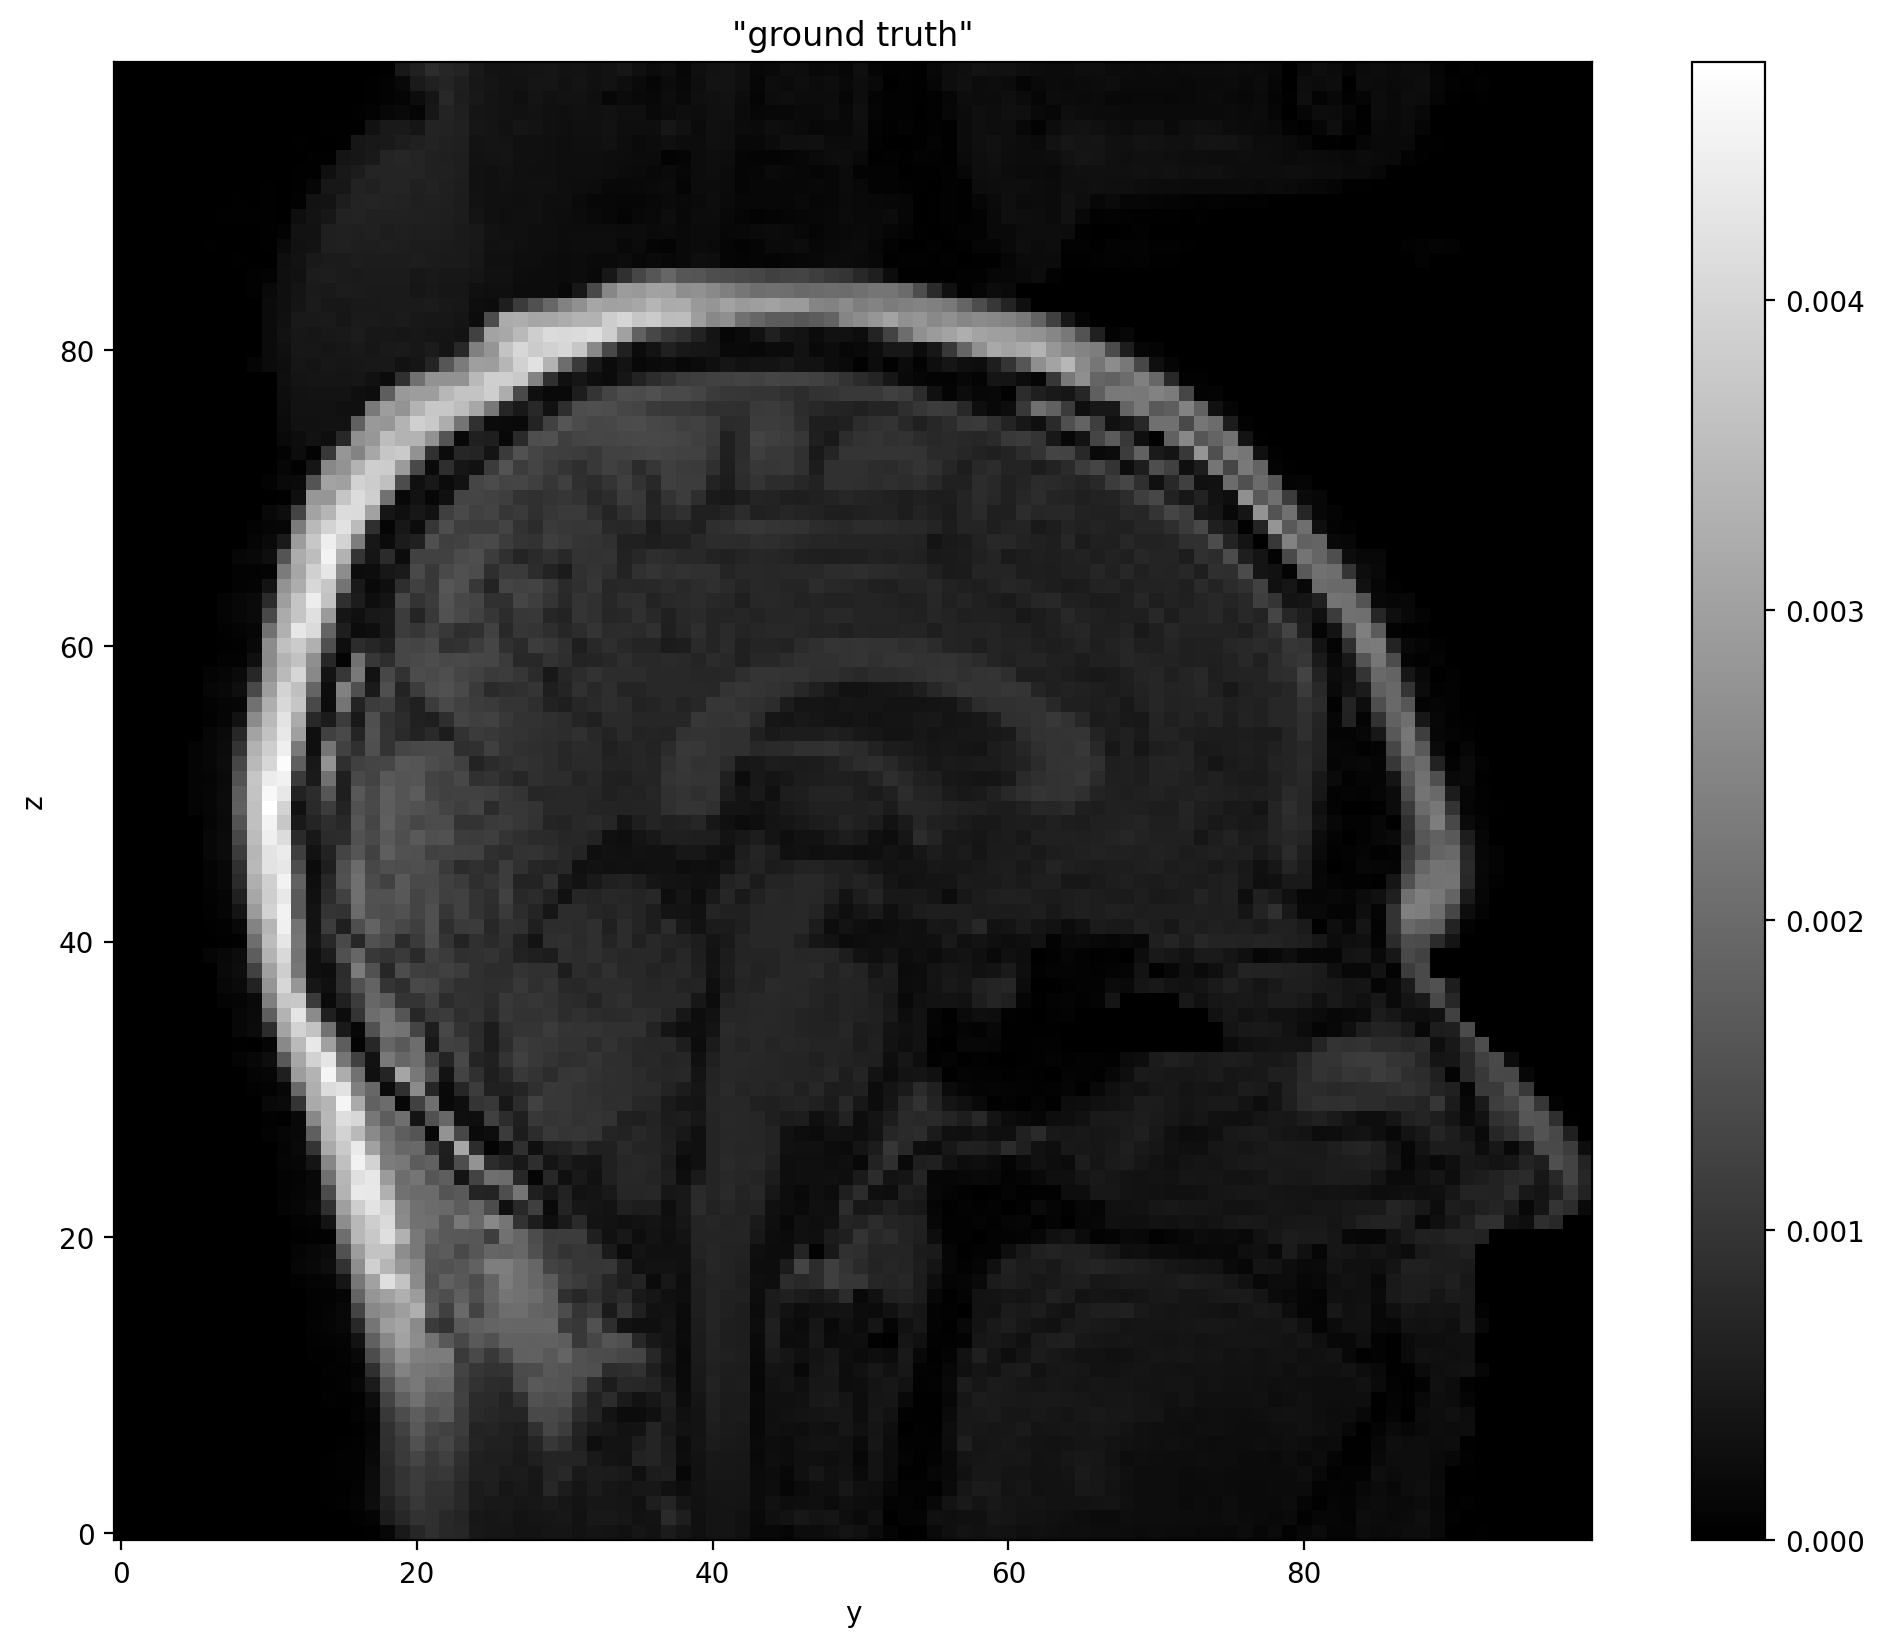

In [7]:
# make ground truth image from fully sampled k-space
if dataType == '2D':
    img_gt = np.sum(np.conj(mps) * sp.ifft(ksp, axes=(-1, -2)), axis=0)
    img_gt /= np.linalg.norm(img_gt)

    plt.figure()
    plt.imshow(np.abs(img_gt), cmap='gray', origin='lower')
    plt.title('"ground truth"')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()
    
elif dataType == '3D':
    img_gt = np.sum(np.conj(mps) * sp.ifft(ksp, axes=(-1, -2, -3)), axis=0)
    img_gt /= np.linalg.norm(img_gt)
    mid3views(np.abs(img_gt), '"ground truth"')

## SENSE Recon

With the sensitivity maps ready, we can now run a SENSE reconstruction using the [SenseRecon](https://sigpy.readthedocs.io/en/latest/generated/sigpy.mri.app.SenseRecon.html#sigpy.mri.app.SenseRecon) `App`. We will use an l2 regularization of 0.01 based on trial-and-error with this dataset. Feel free to change it!

Again, we can run the reconstruction on GPU if we specify the `device` option.

SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

Time elapsed : 18.769079208374023


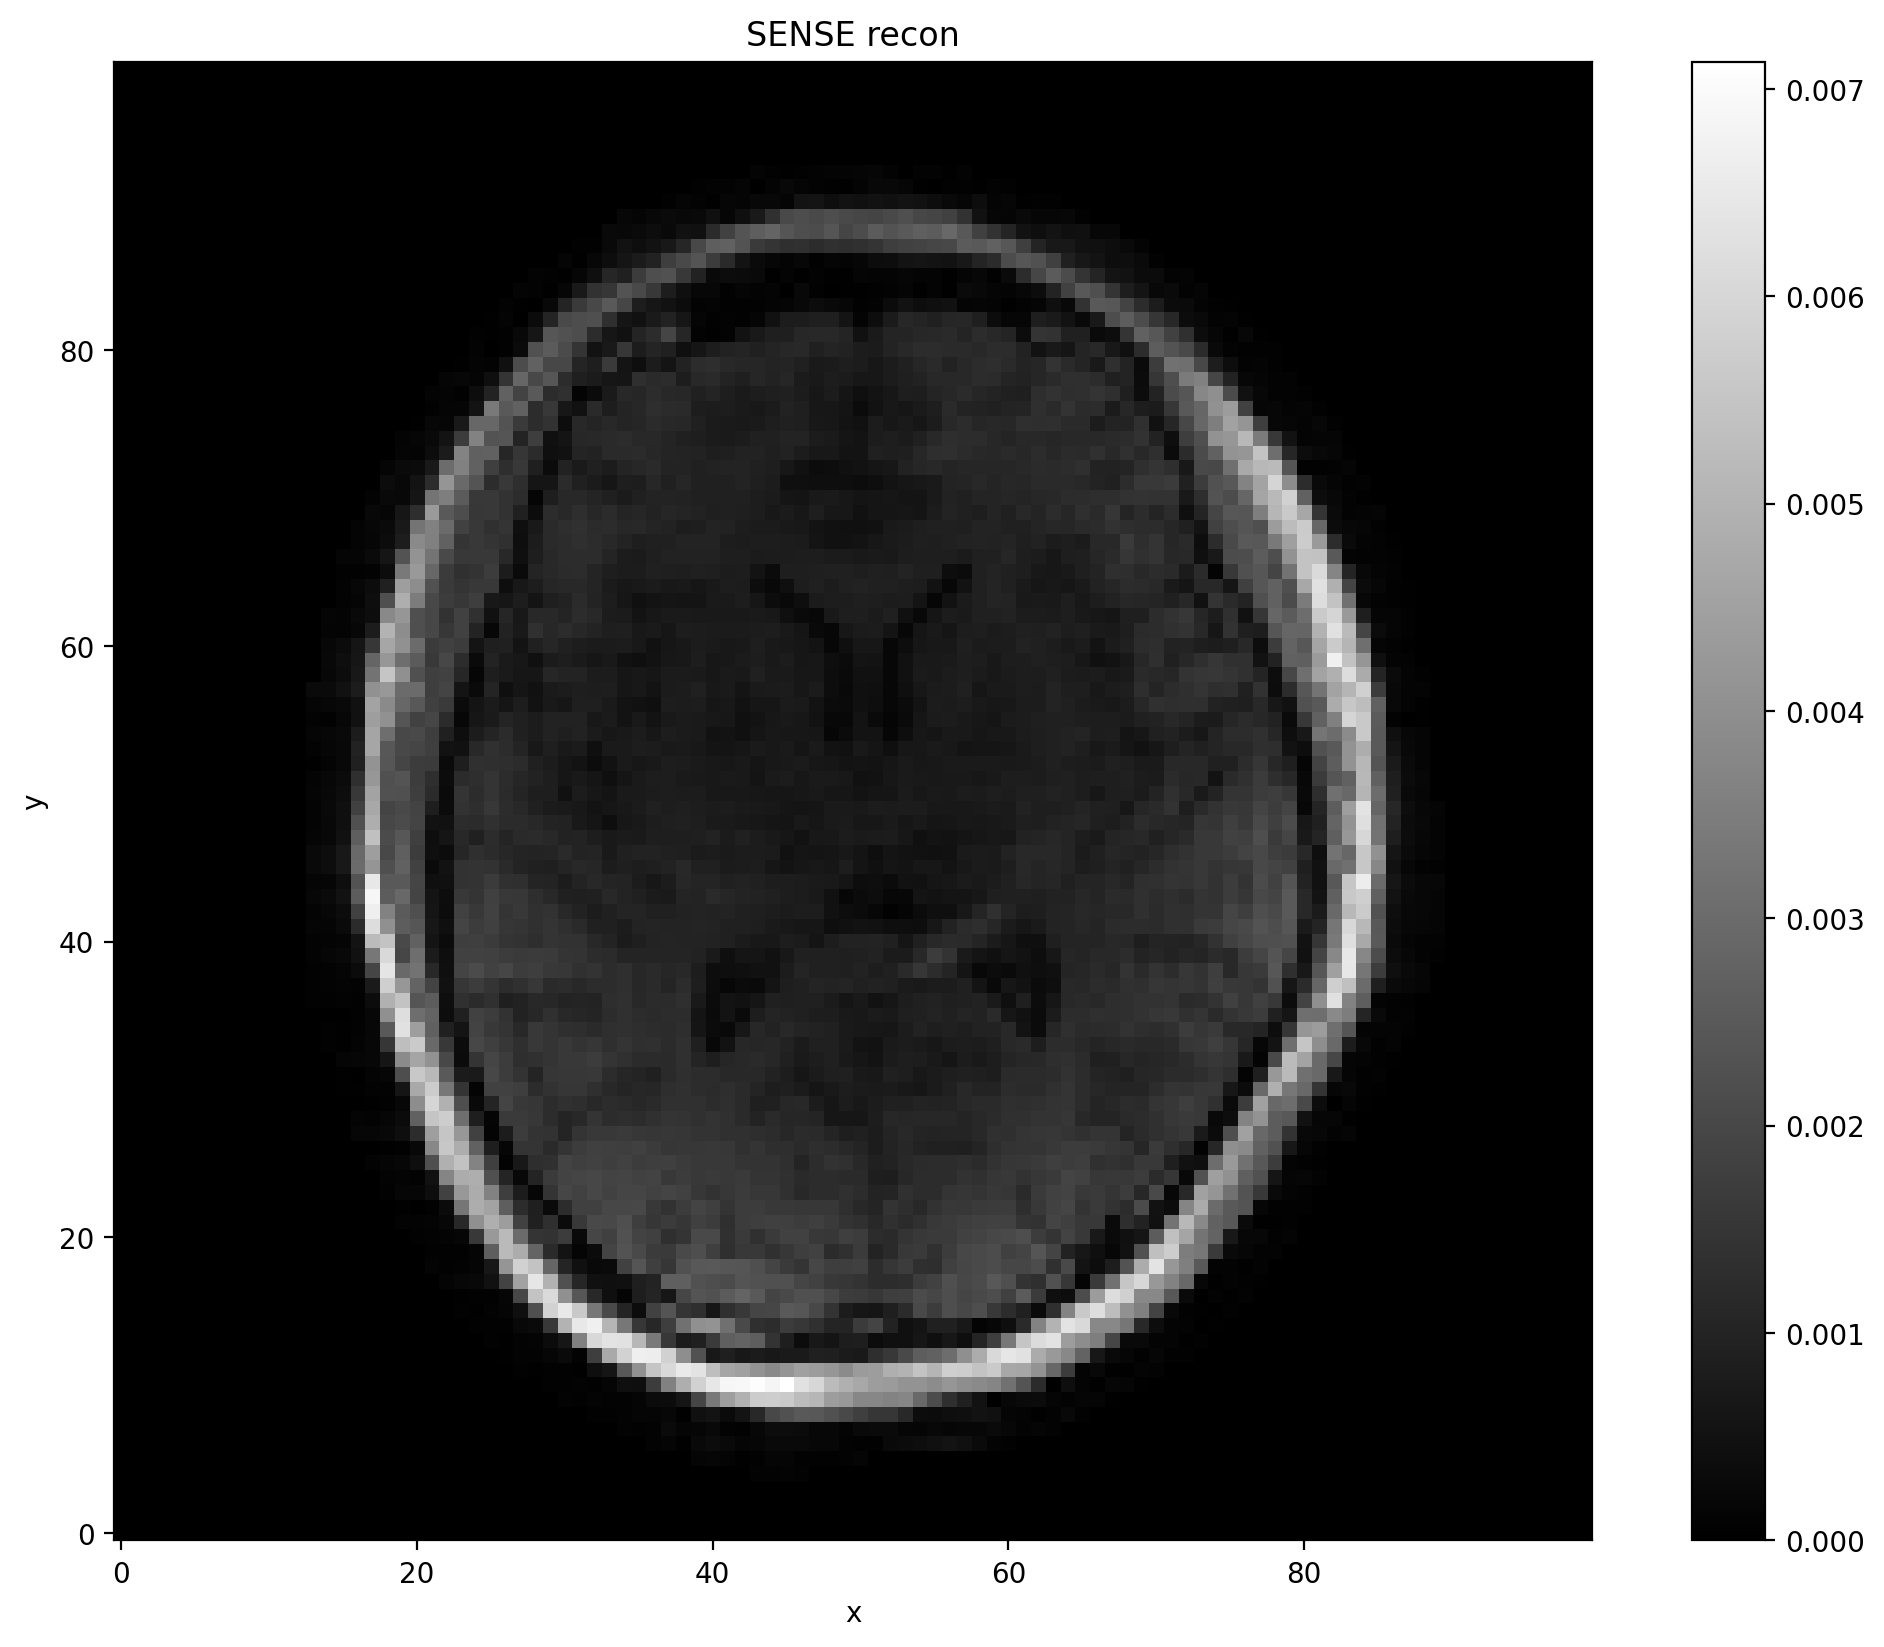

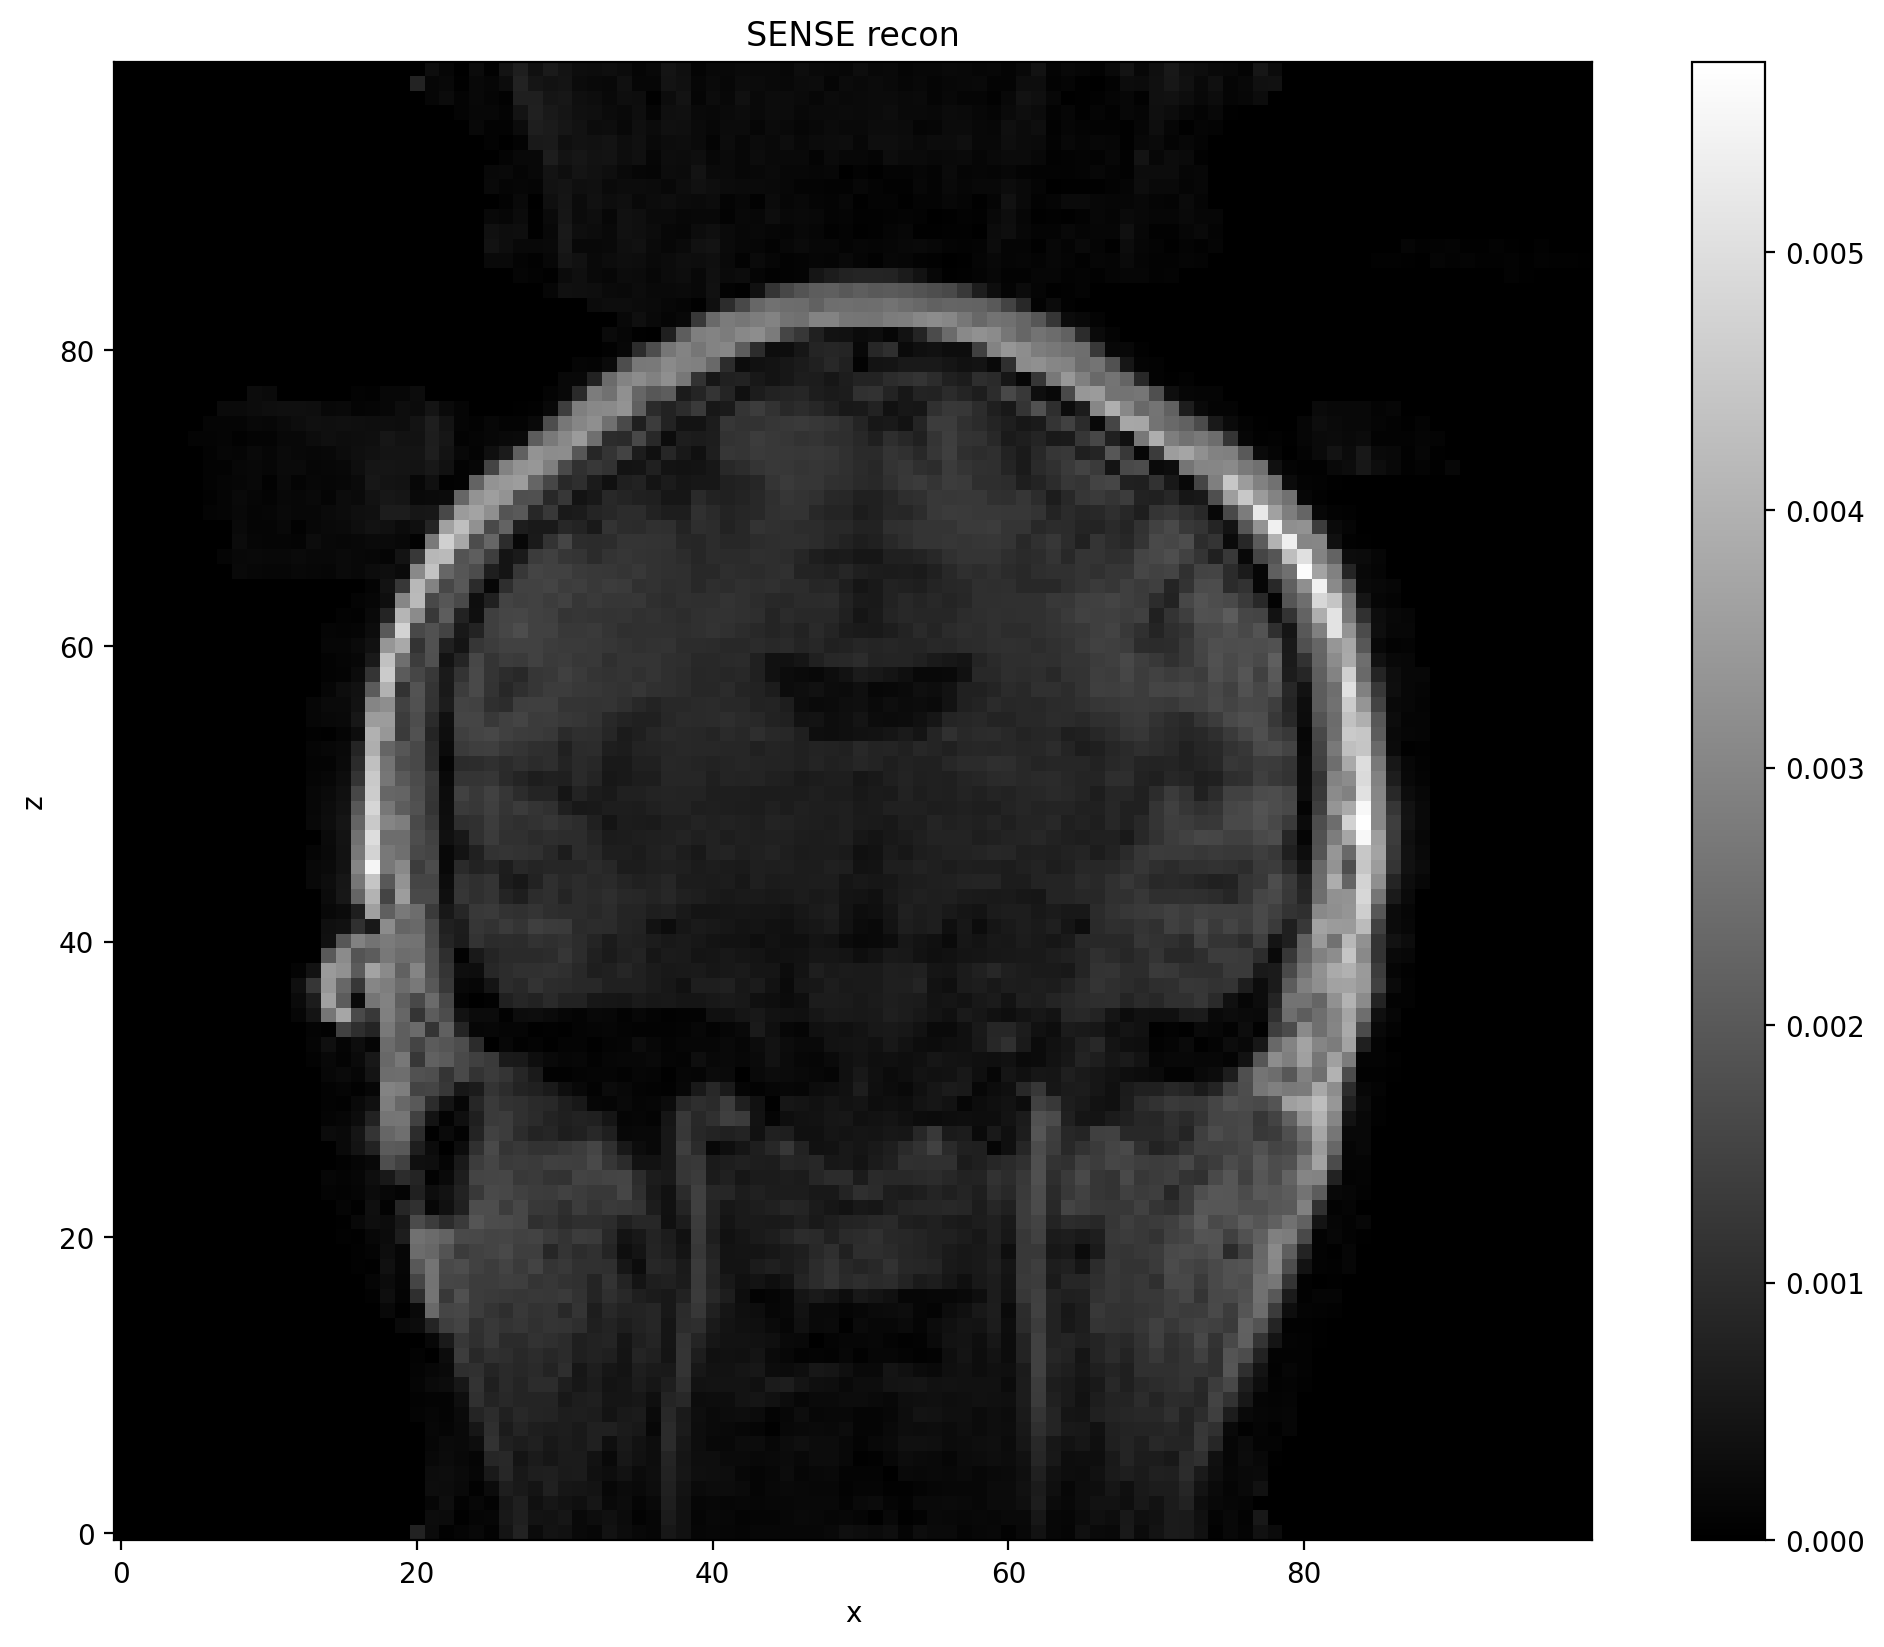

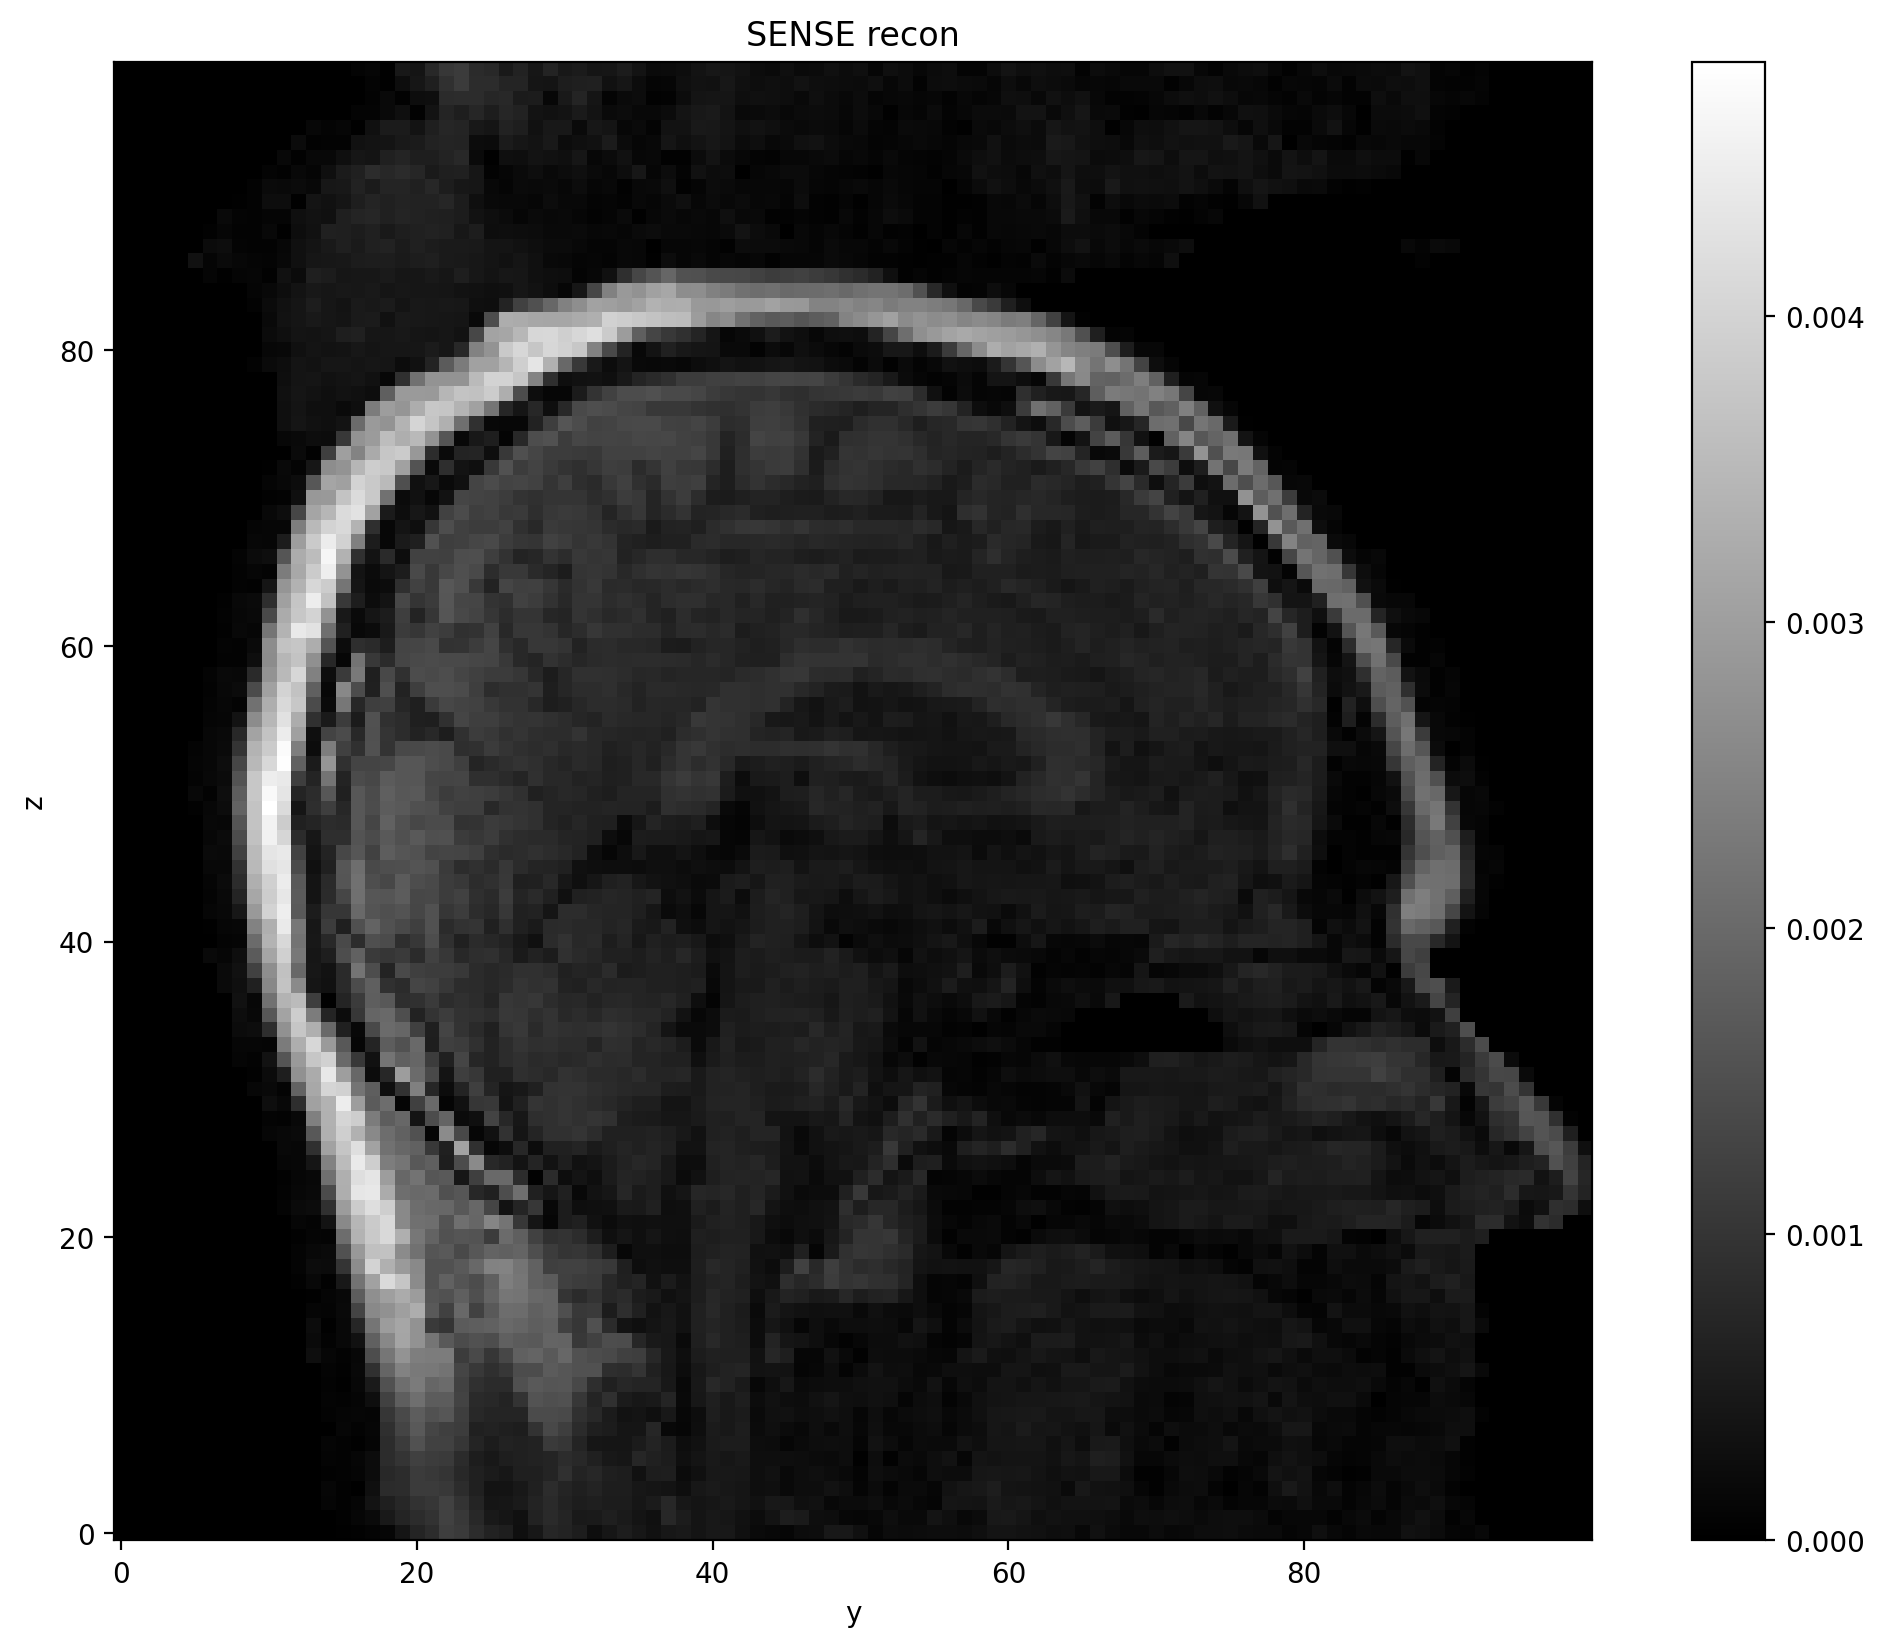

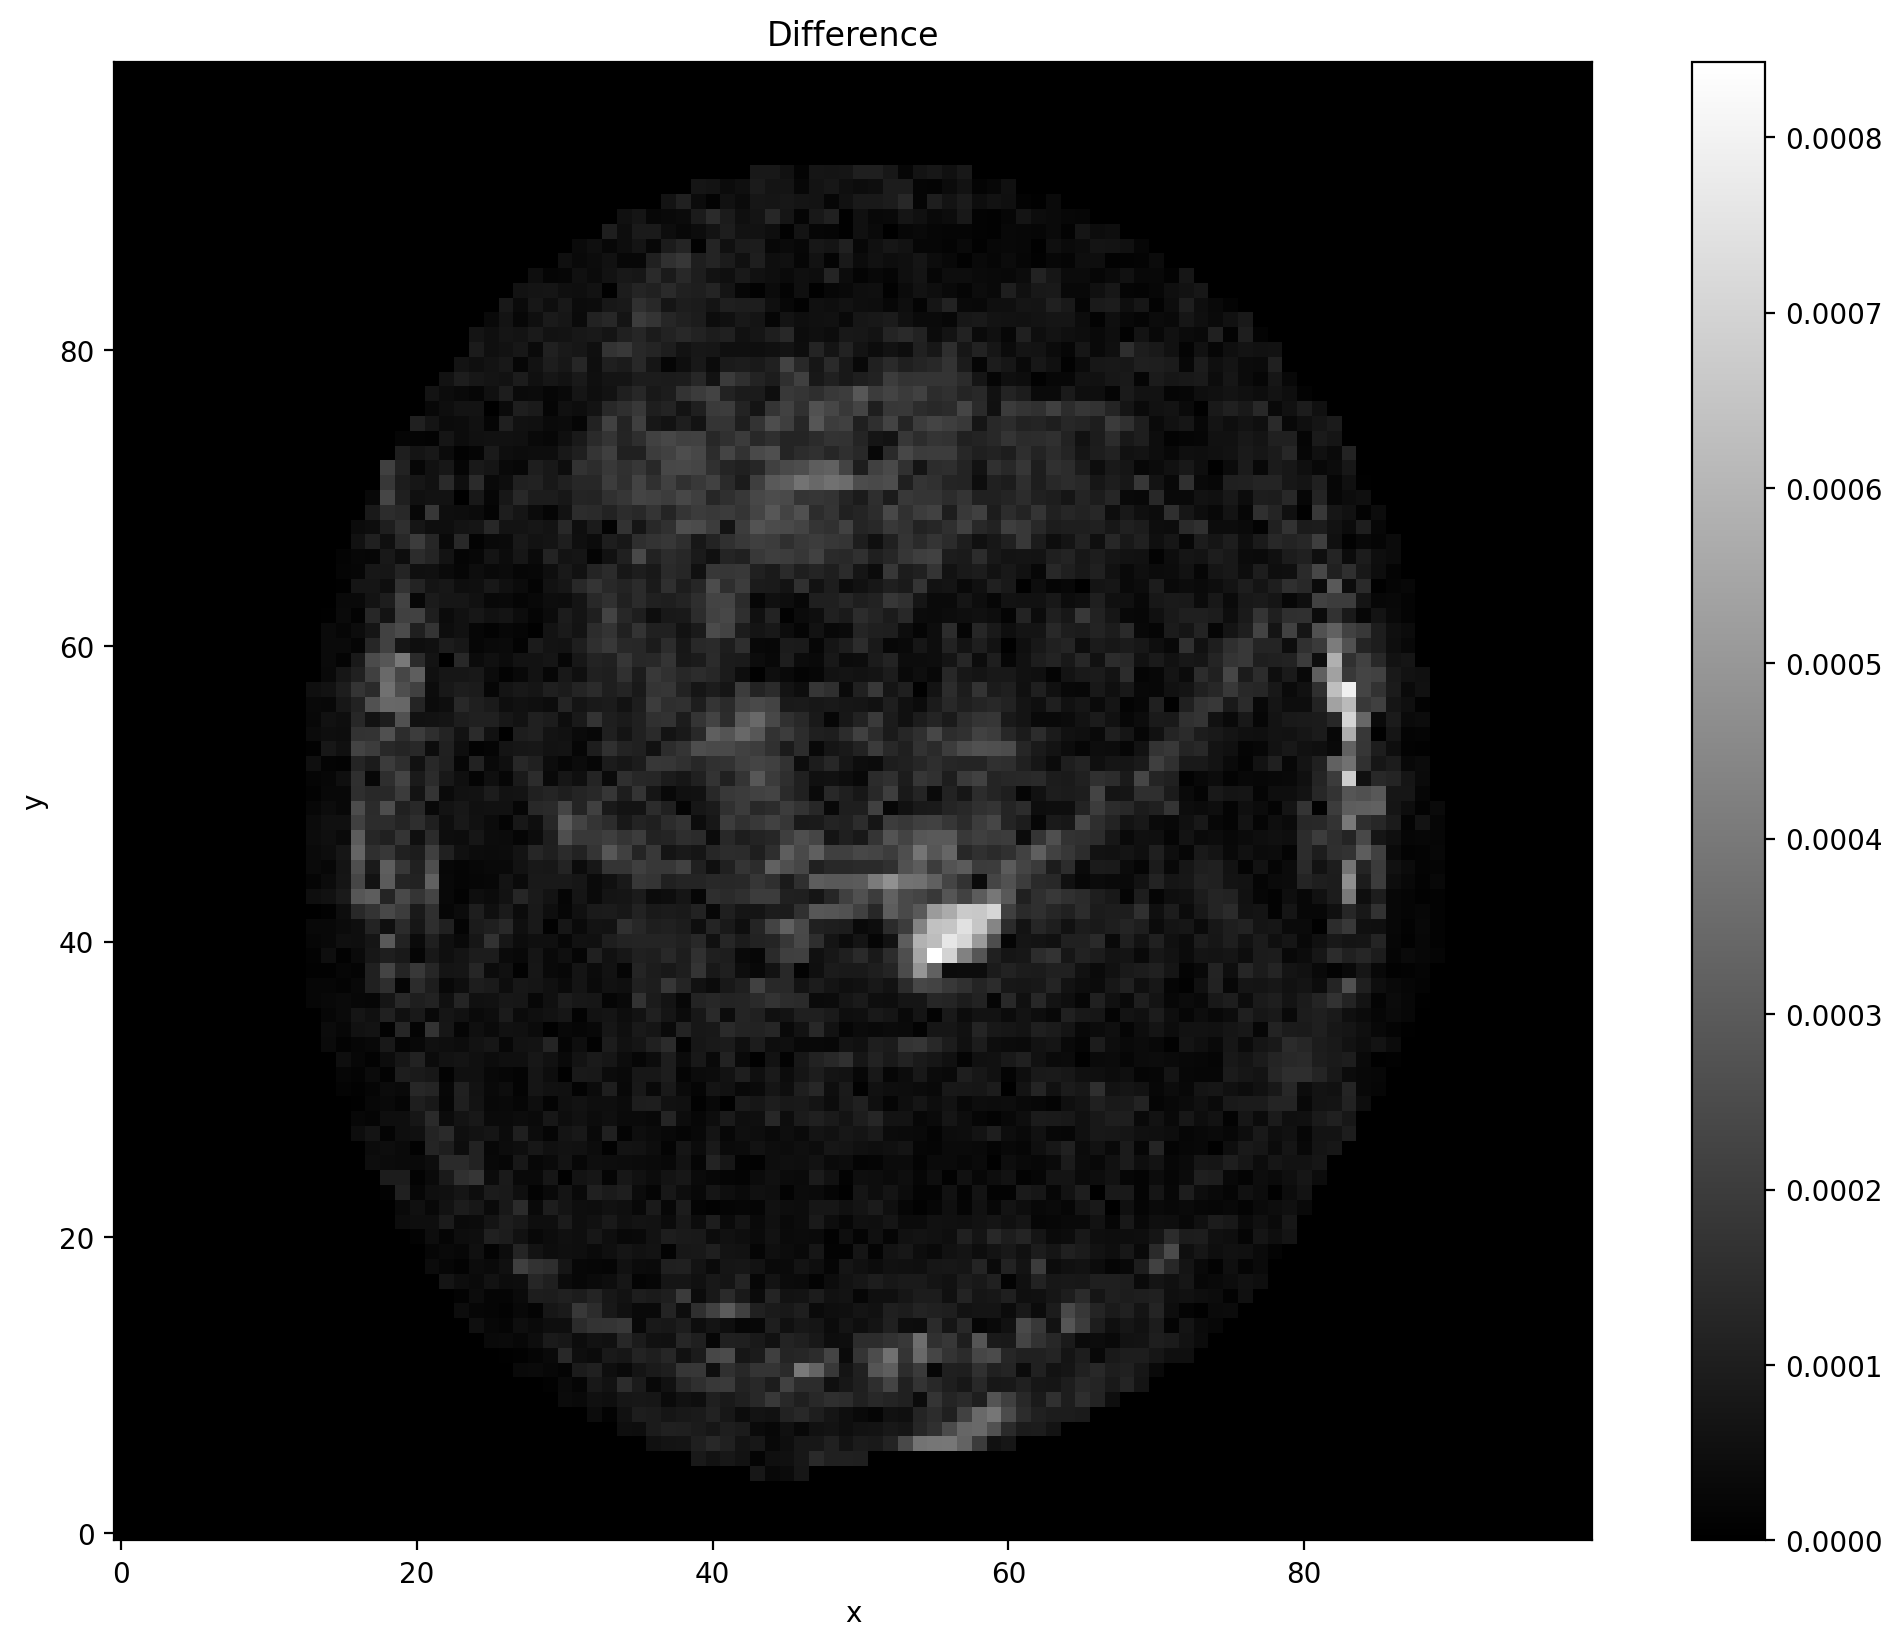

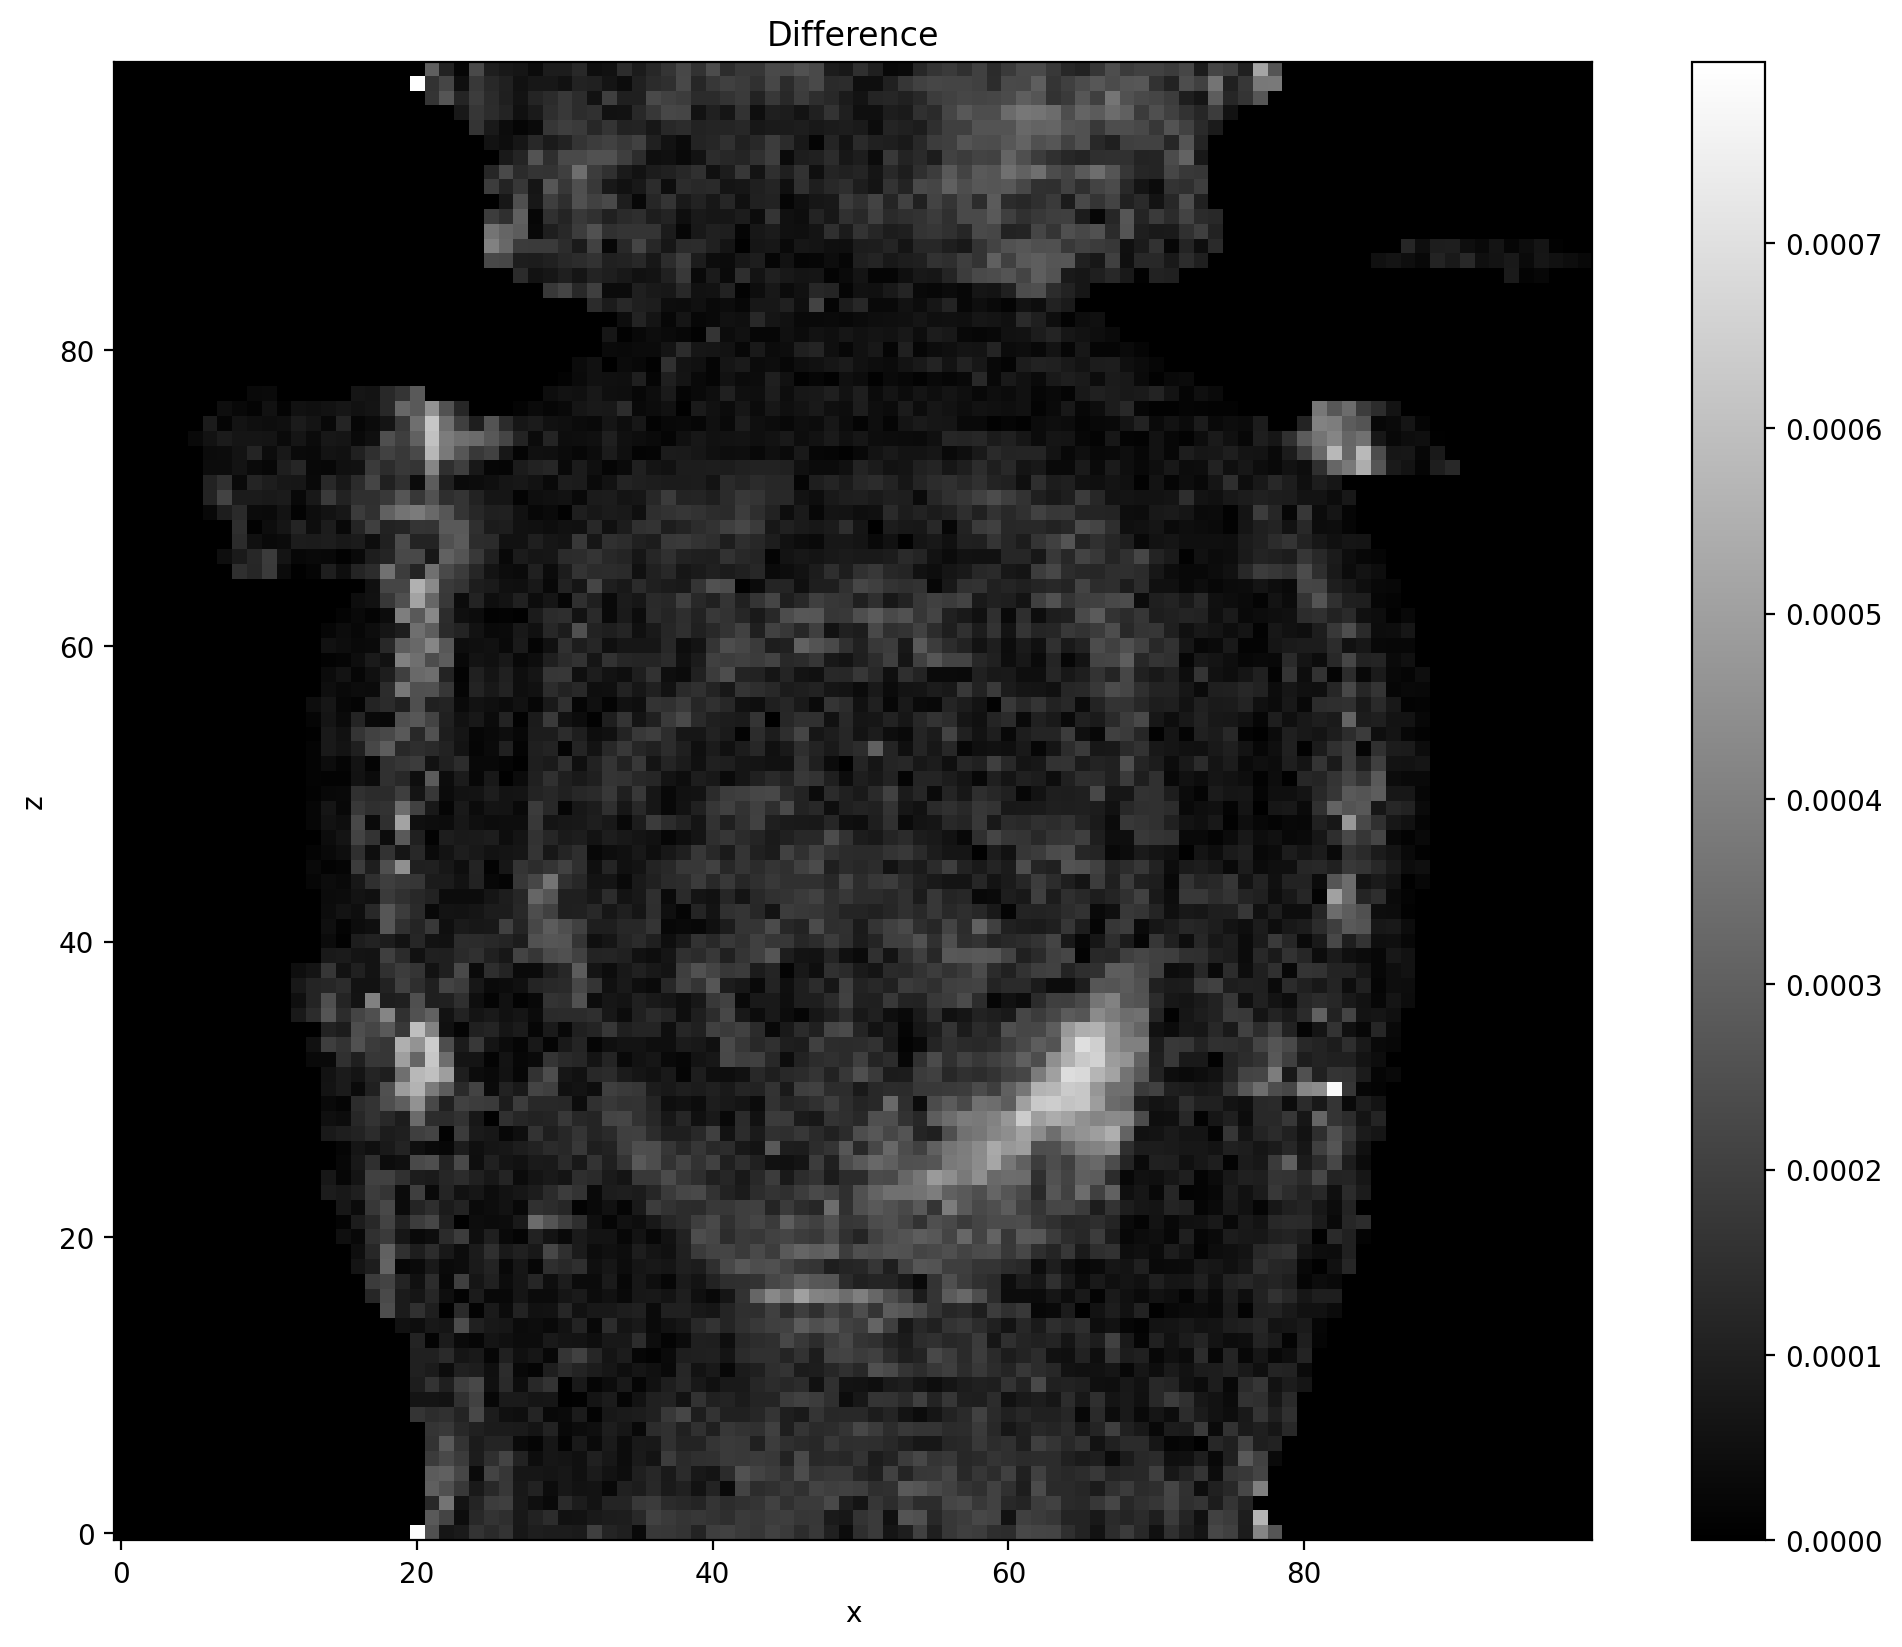

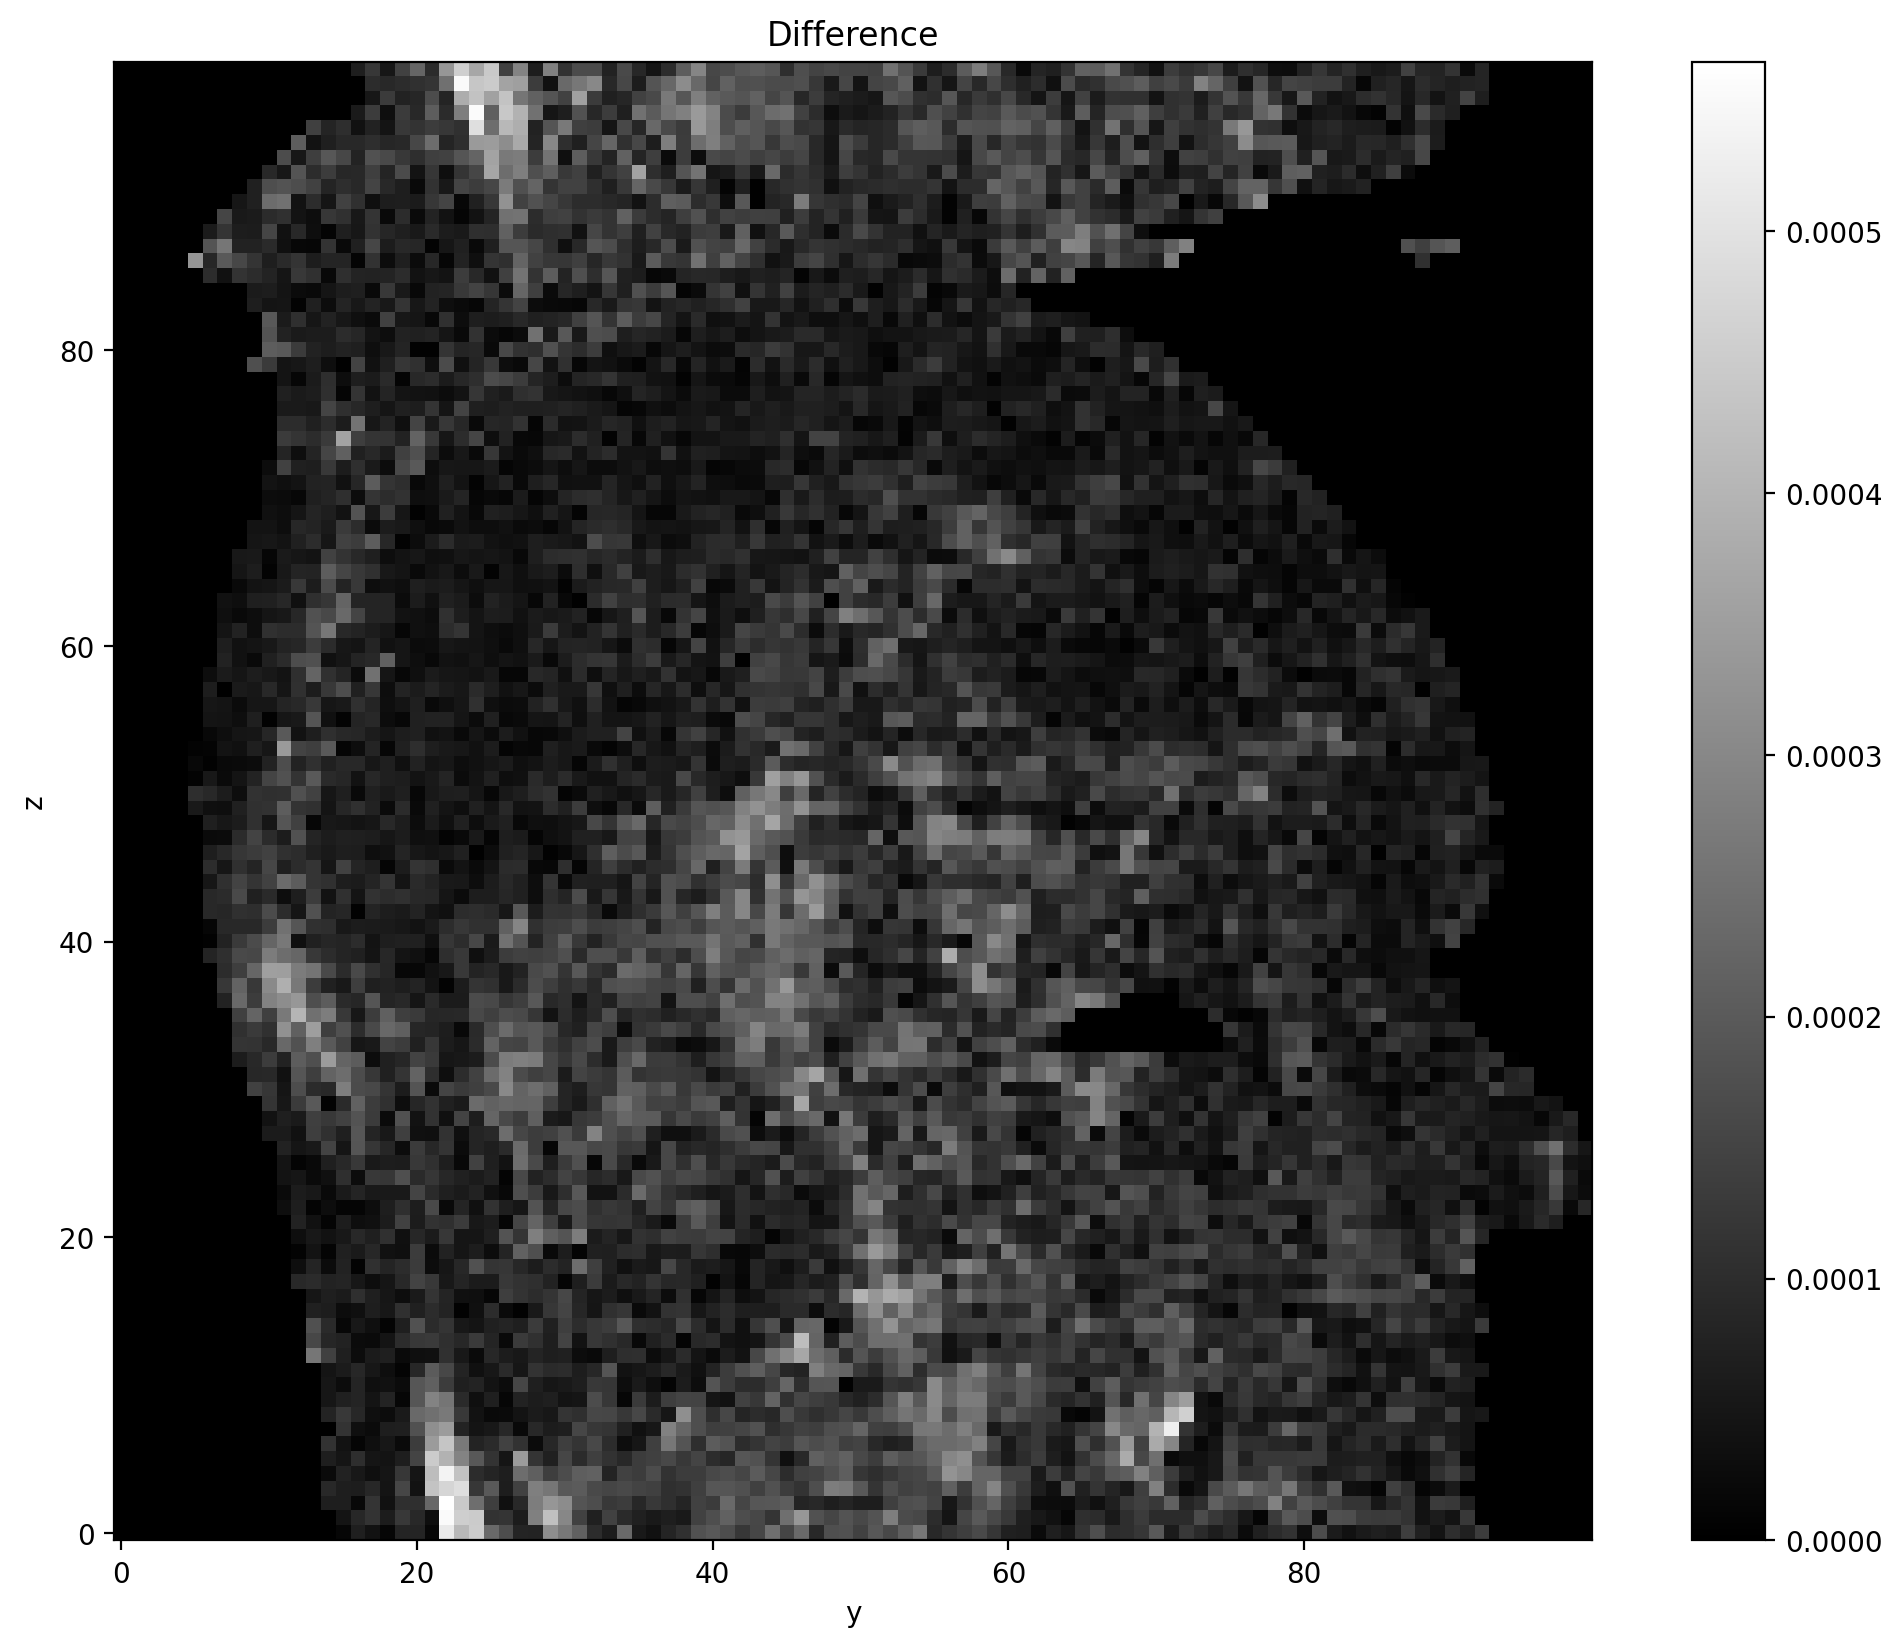

In [8]:
lamda = 0.01
start = time.time()
img_sense = mr.app.SenseRecon(ksp_us, mps, lamda=lamda, device=gpu_id).run().get()
end = time.time()
print(f'Time elapsed : {end - start}')
img_sense /= np.linalg.norm(img_sense)

if dataType == '2D':
    plt.figure()
    plt.imshow(np.abs(img_sense), cmap='gray', origin='lower')
    plt.title('SENSE recon')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()

    plt.figure()
    plt.imshow(np.abs(img_sense - img_gt), cmap='gray', origin='lower')
    plt.title('Difference')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()
    
elif dataType == '3D':
    mid3views(np.abs(img_sense), 'SENSE recon')
    mid3views(np.abs(img_sense - img_gt), 'Difference')

# 3D times:
# Quickstep CPU: 9 m 11 s
# Quickstep GPU: 16 s

## L1 Wavelet Regularized Reconstruction

Similarly, we can perform an l1-wavelet regularized reconstruction using [L1WaveletRecon](https://sigpy.readthedocs.io/en/latest/generated/sigpy.mri.app.L1WaveletRecon.html#sigpy.mri.app.L1WaveletRecon).

In [9]:
import torch
torch.cuda.empty_cache()

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

Time elapsed: 40.0711567401886


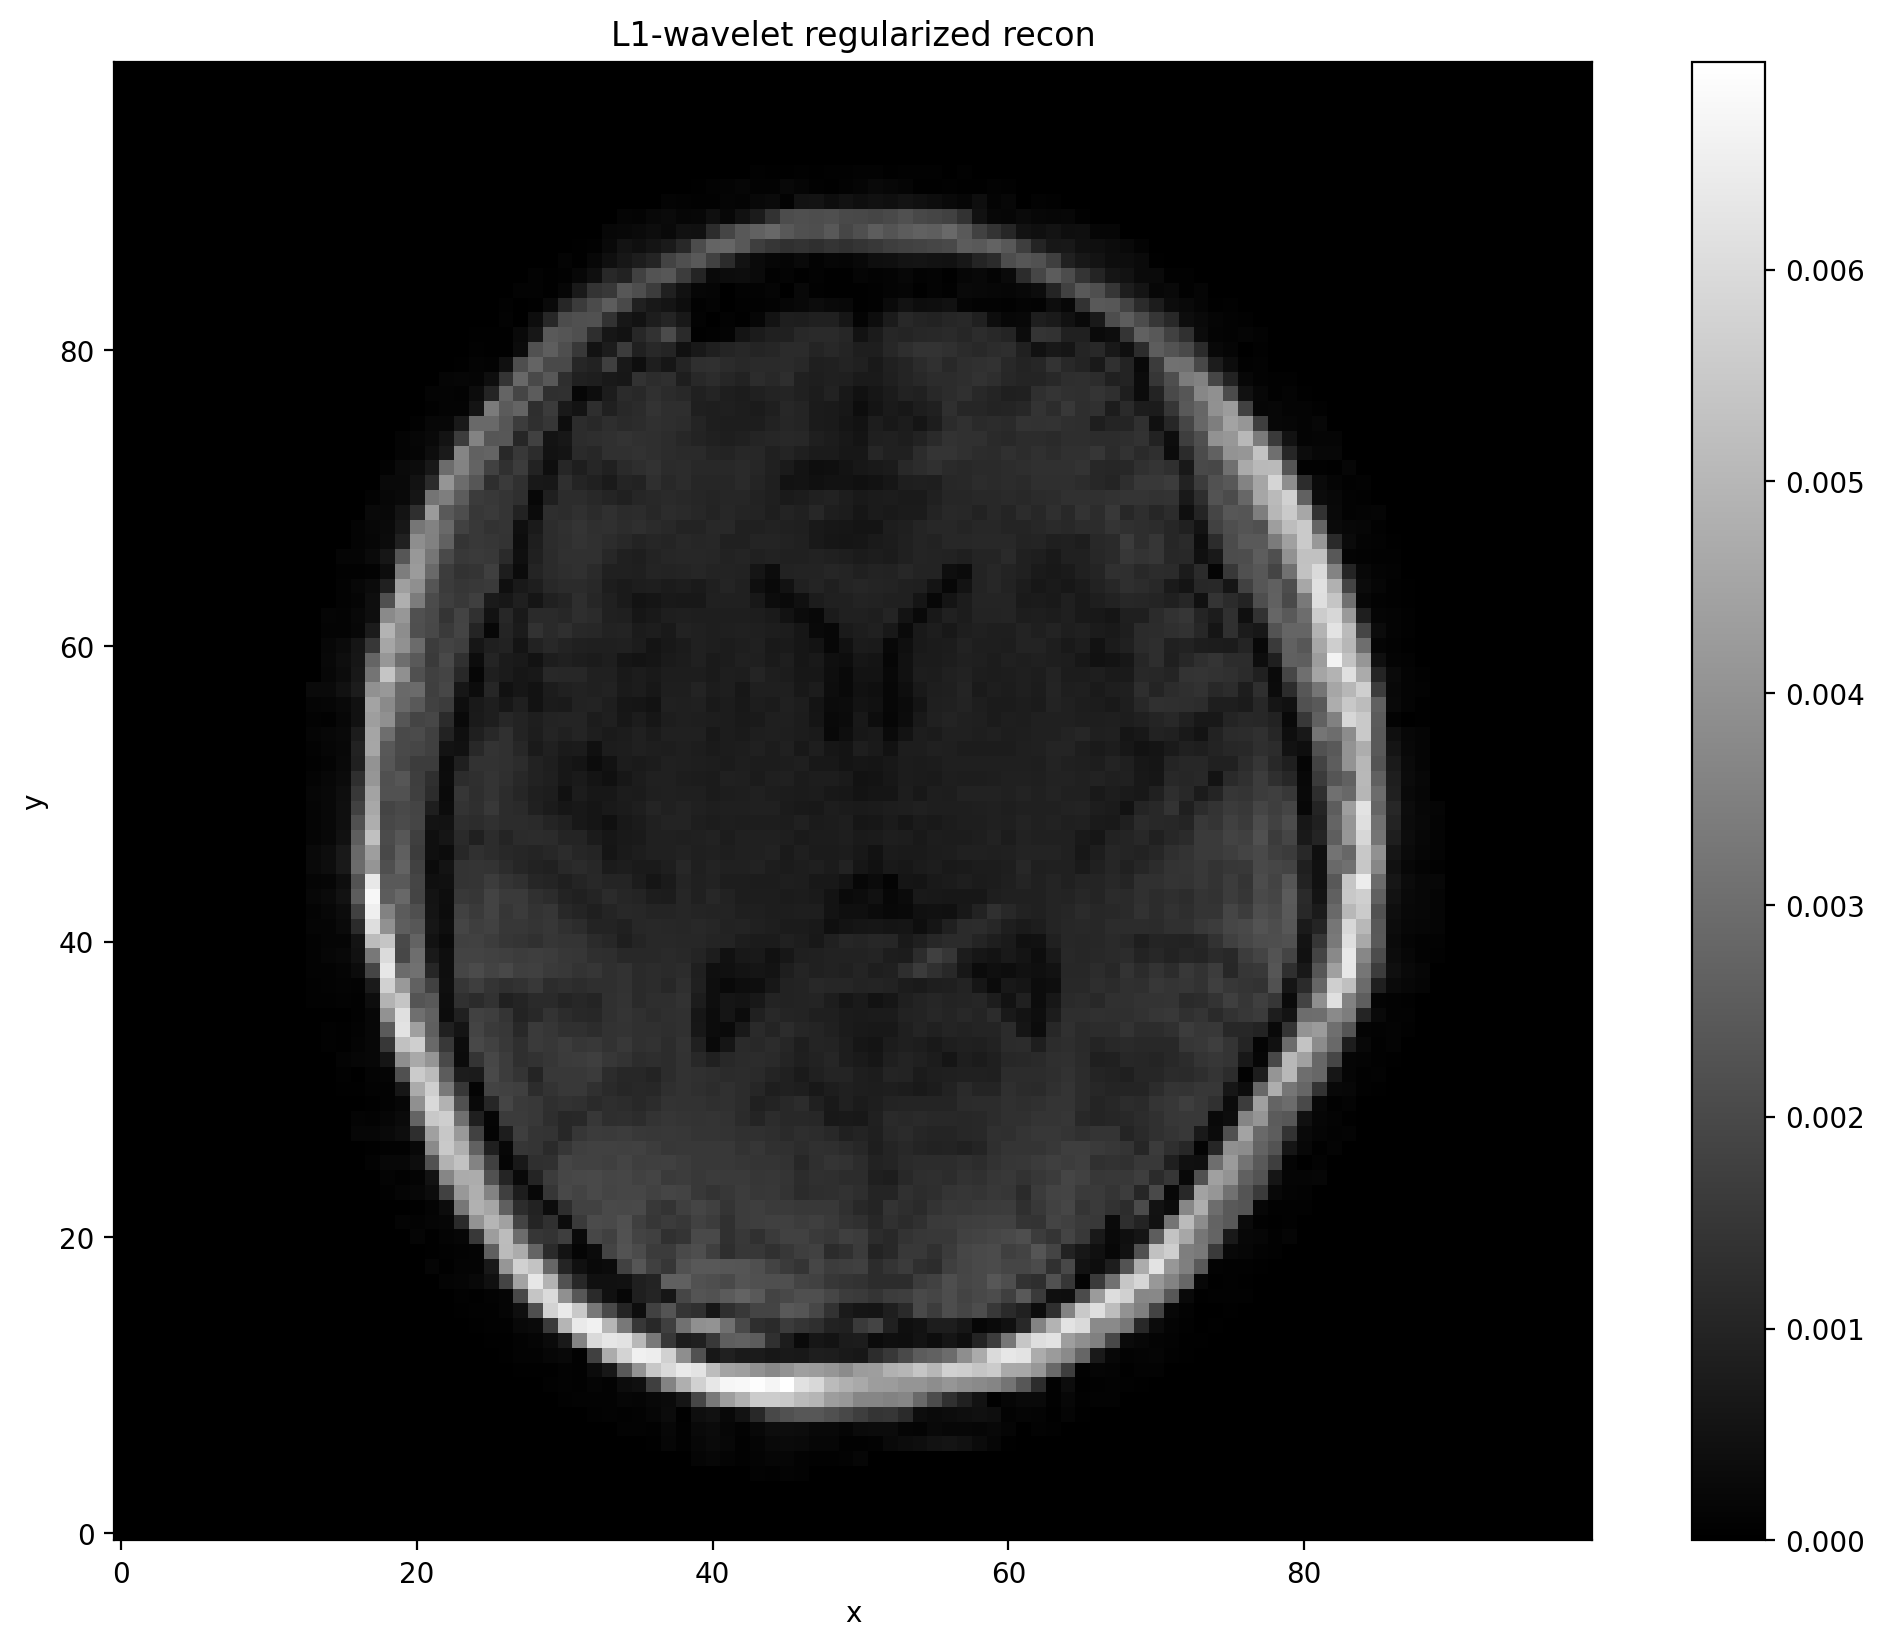

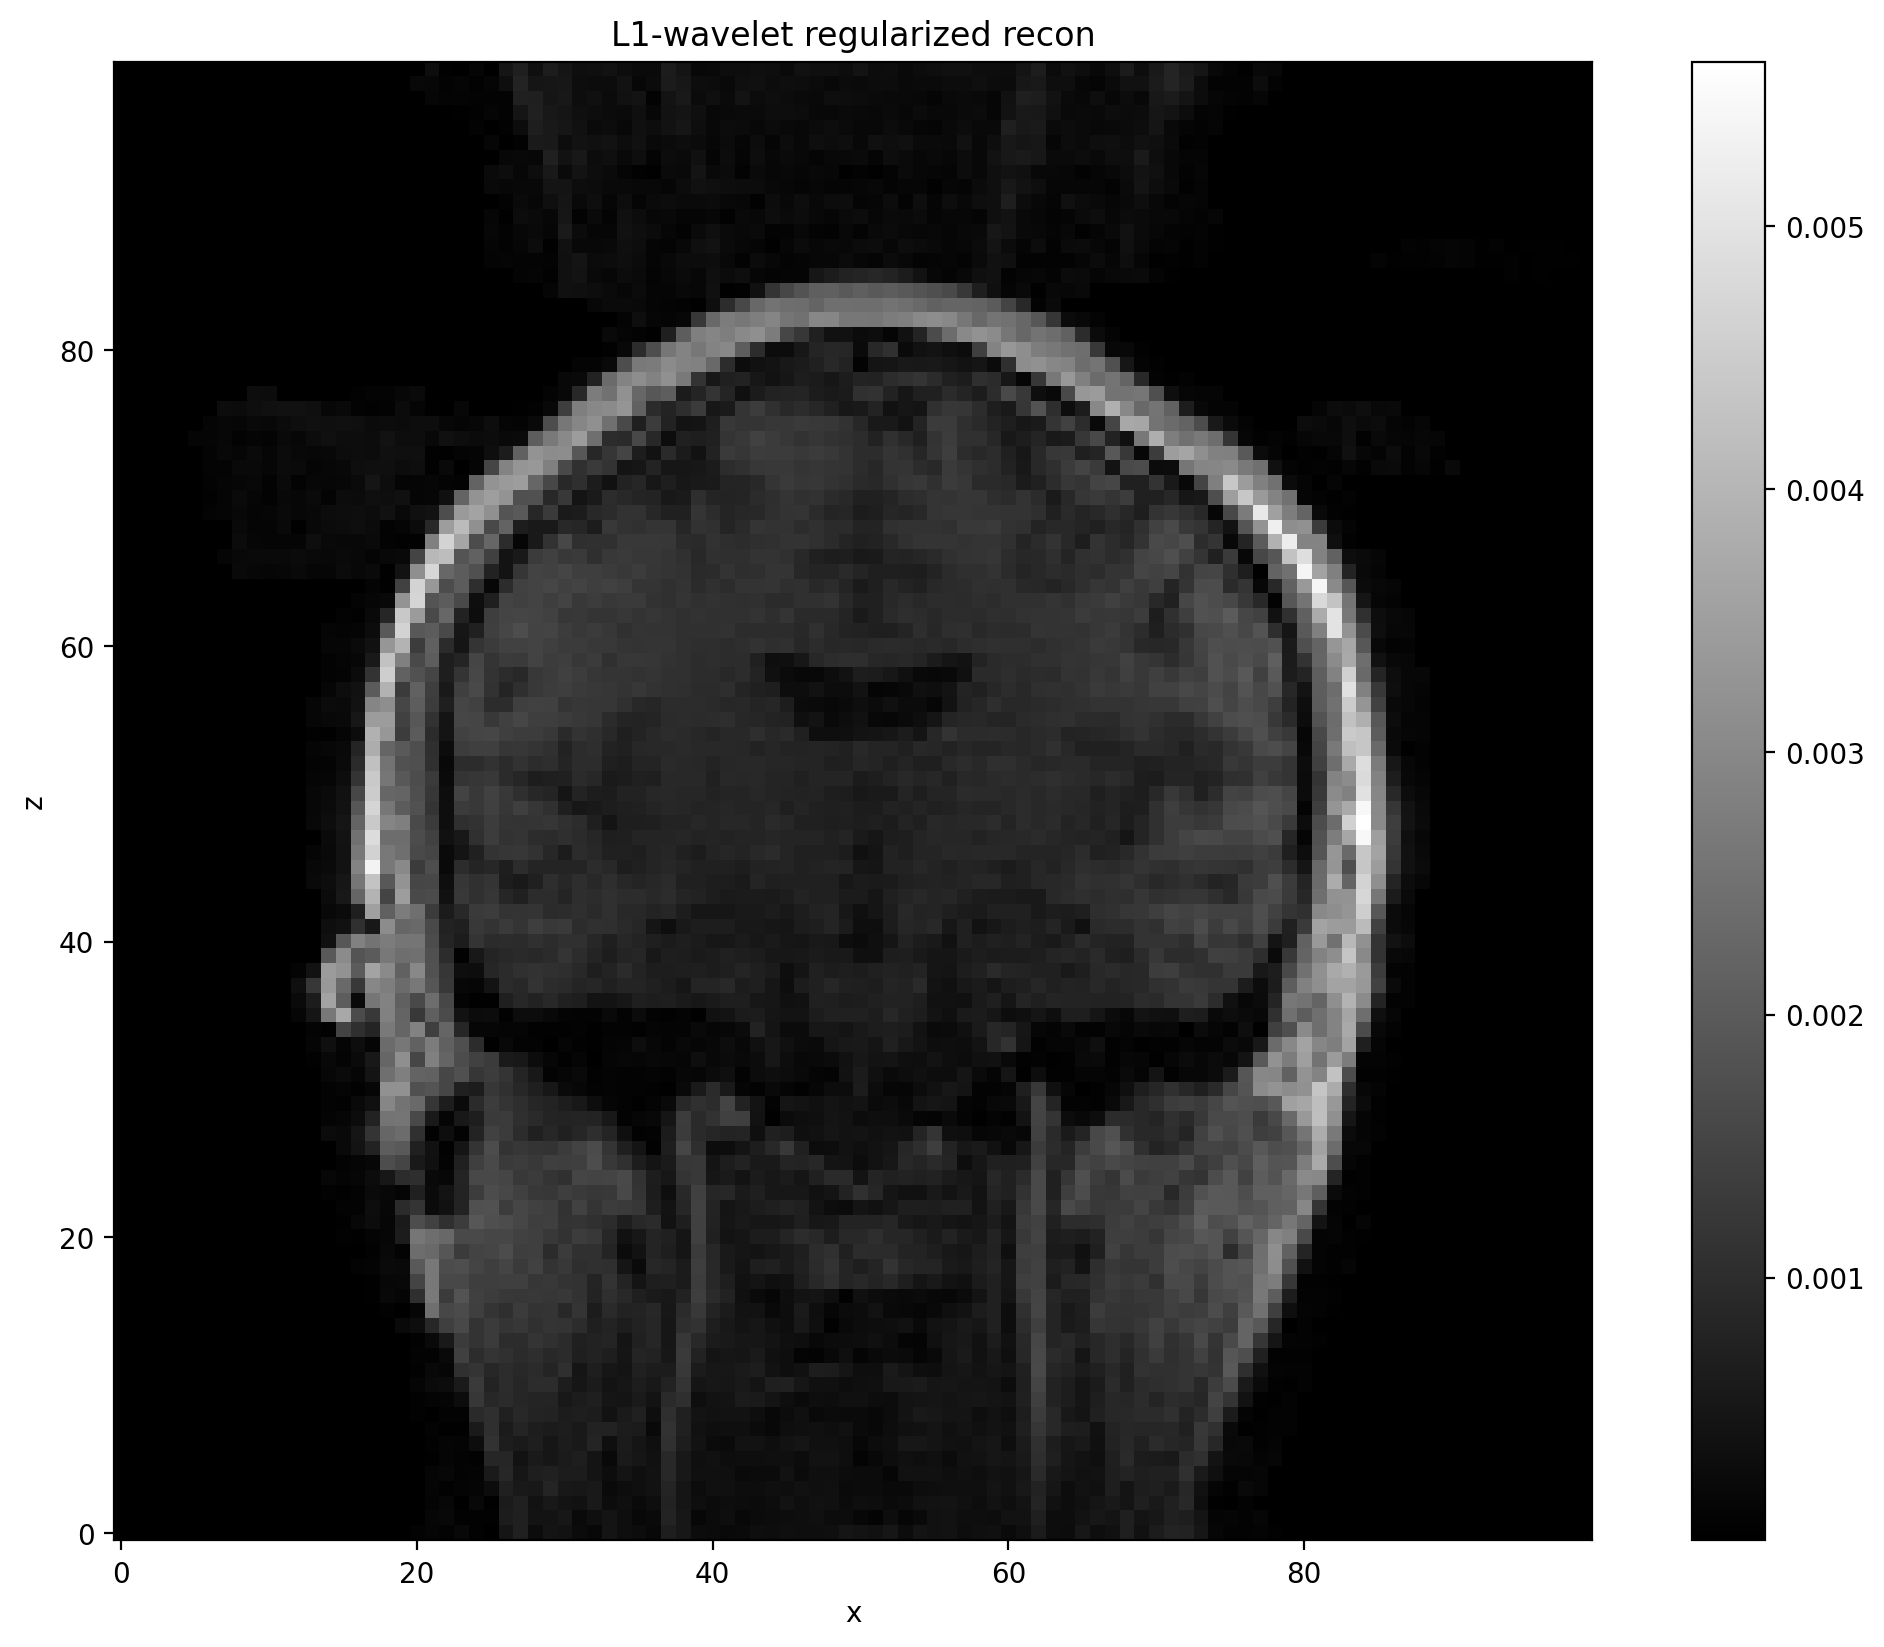

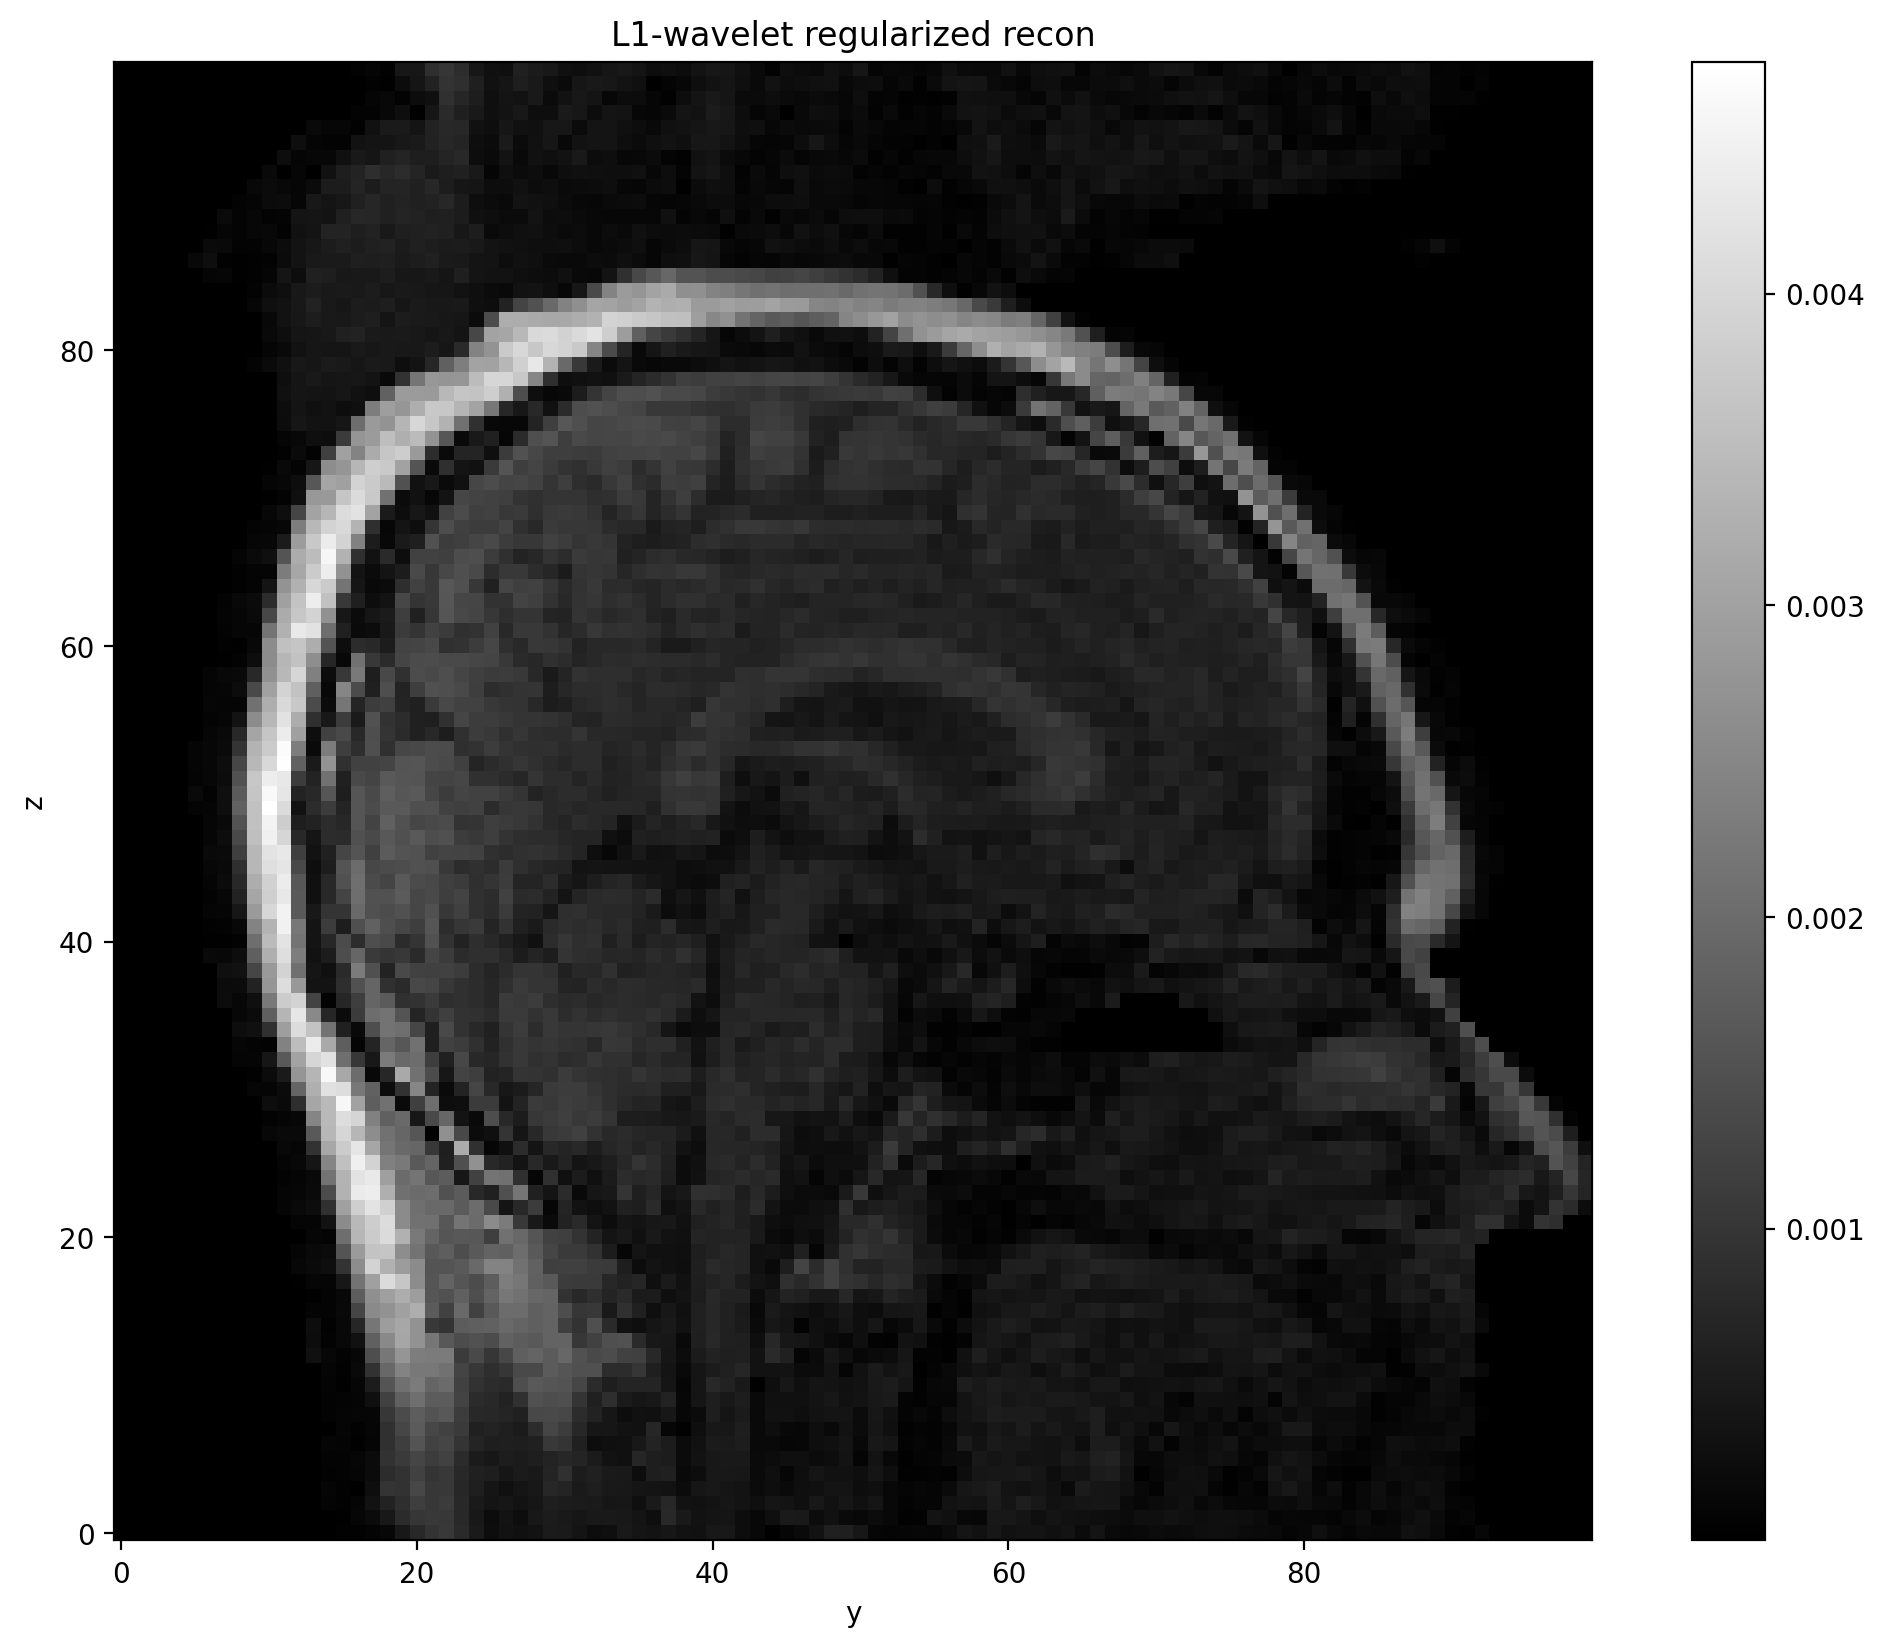

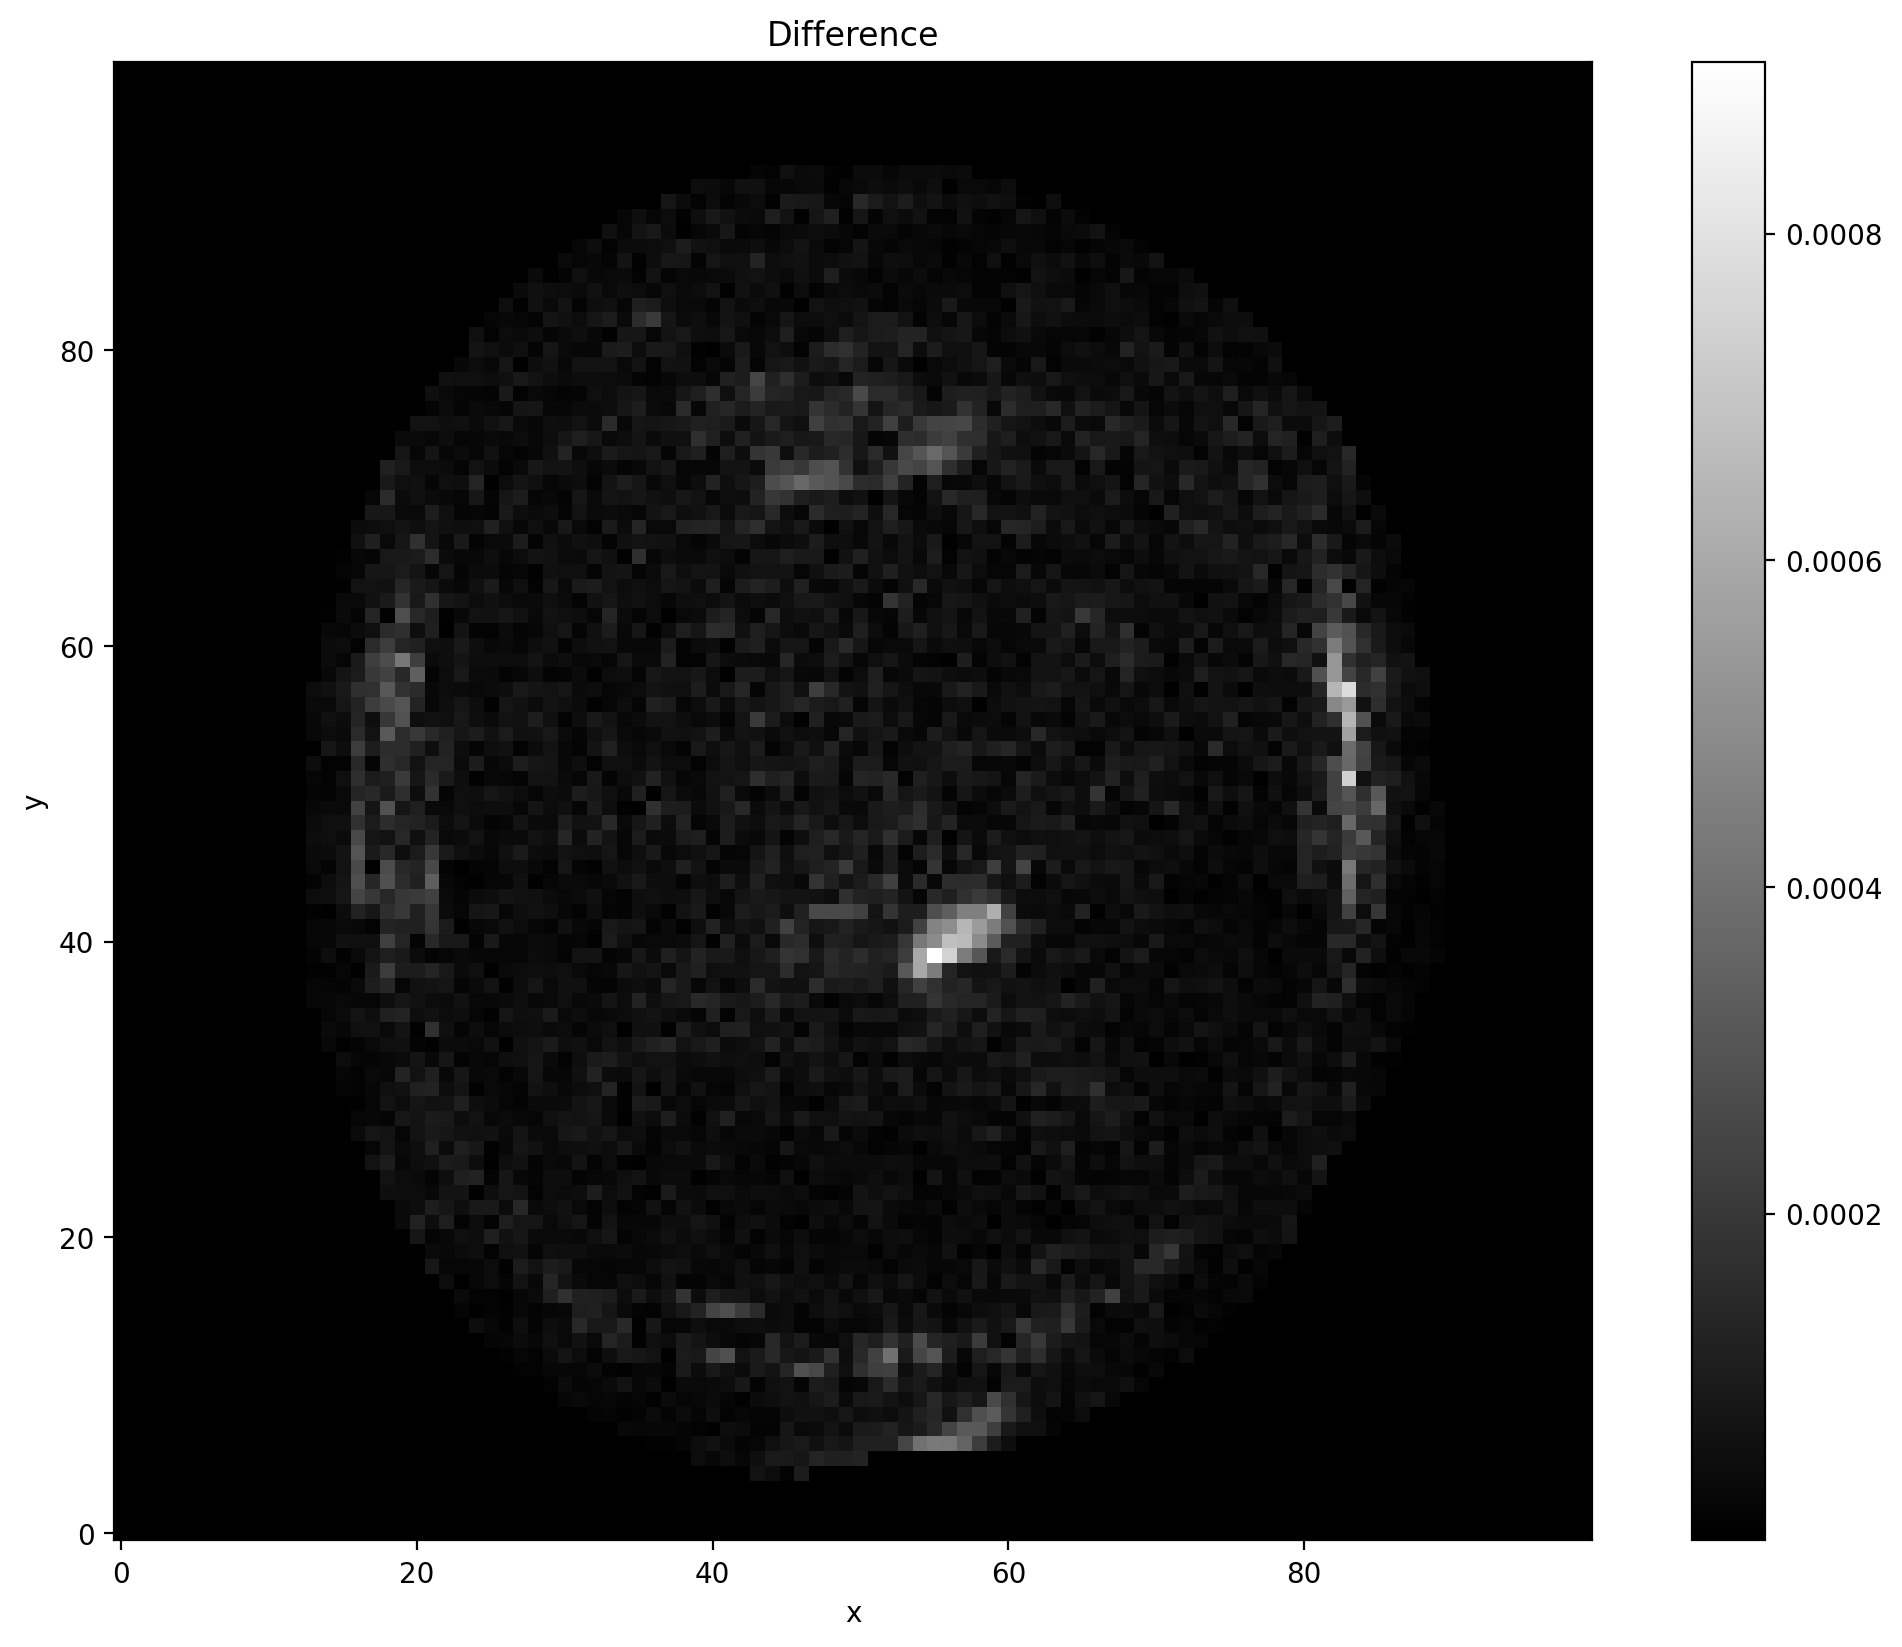

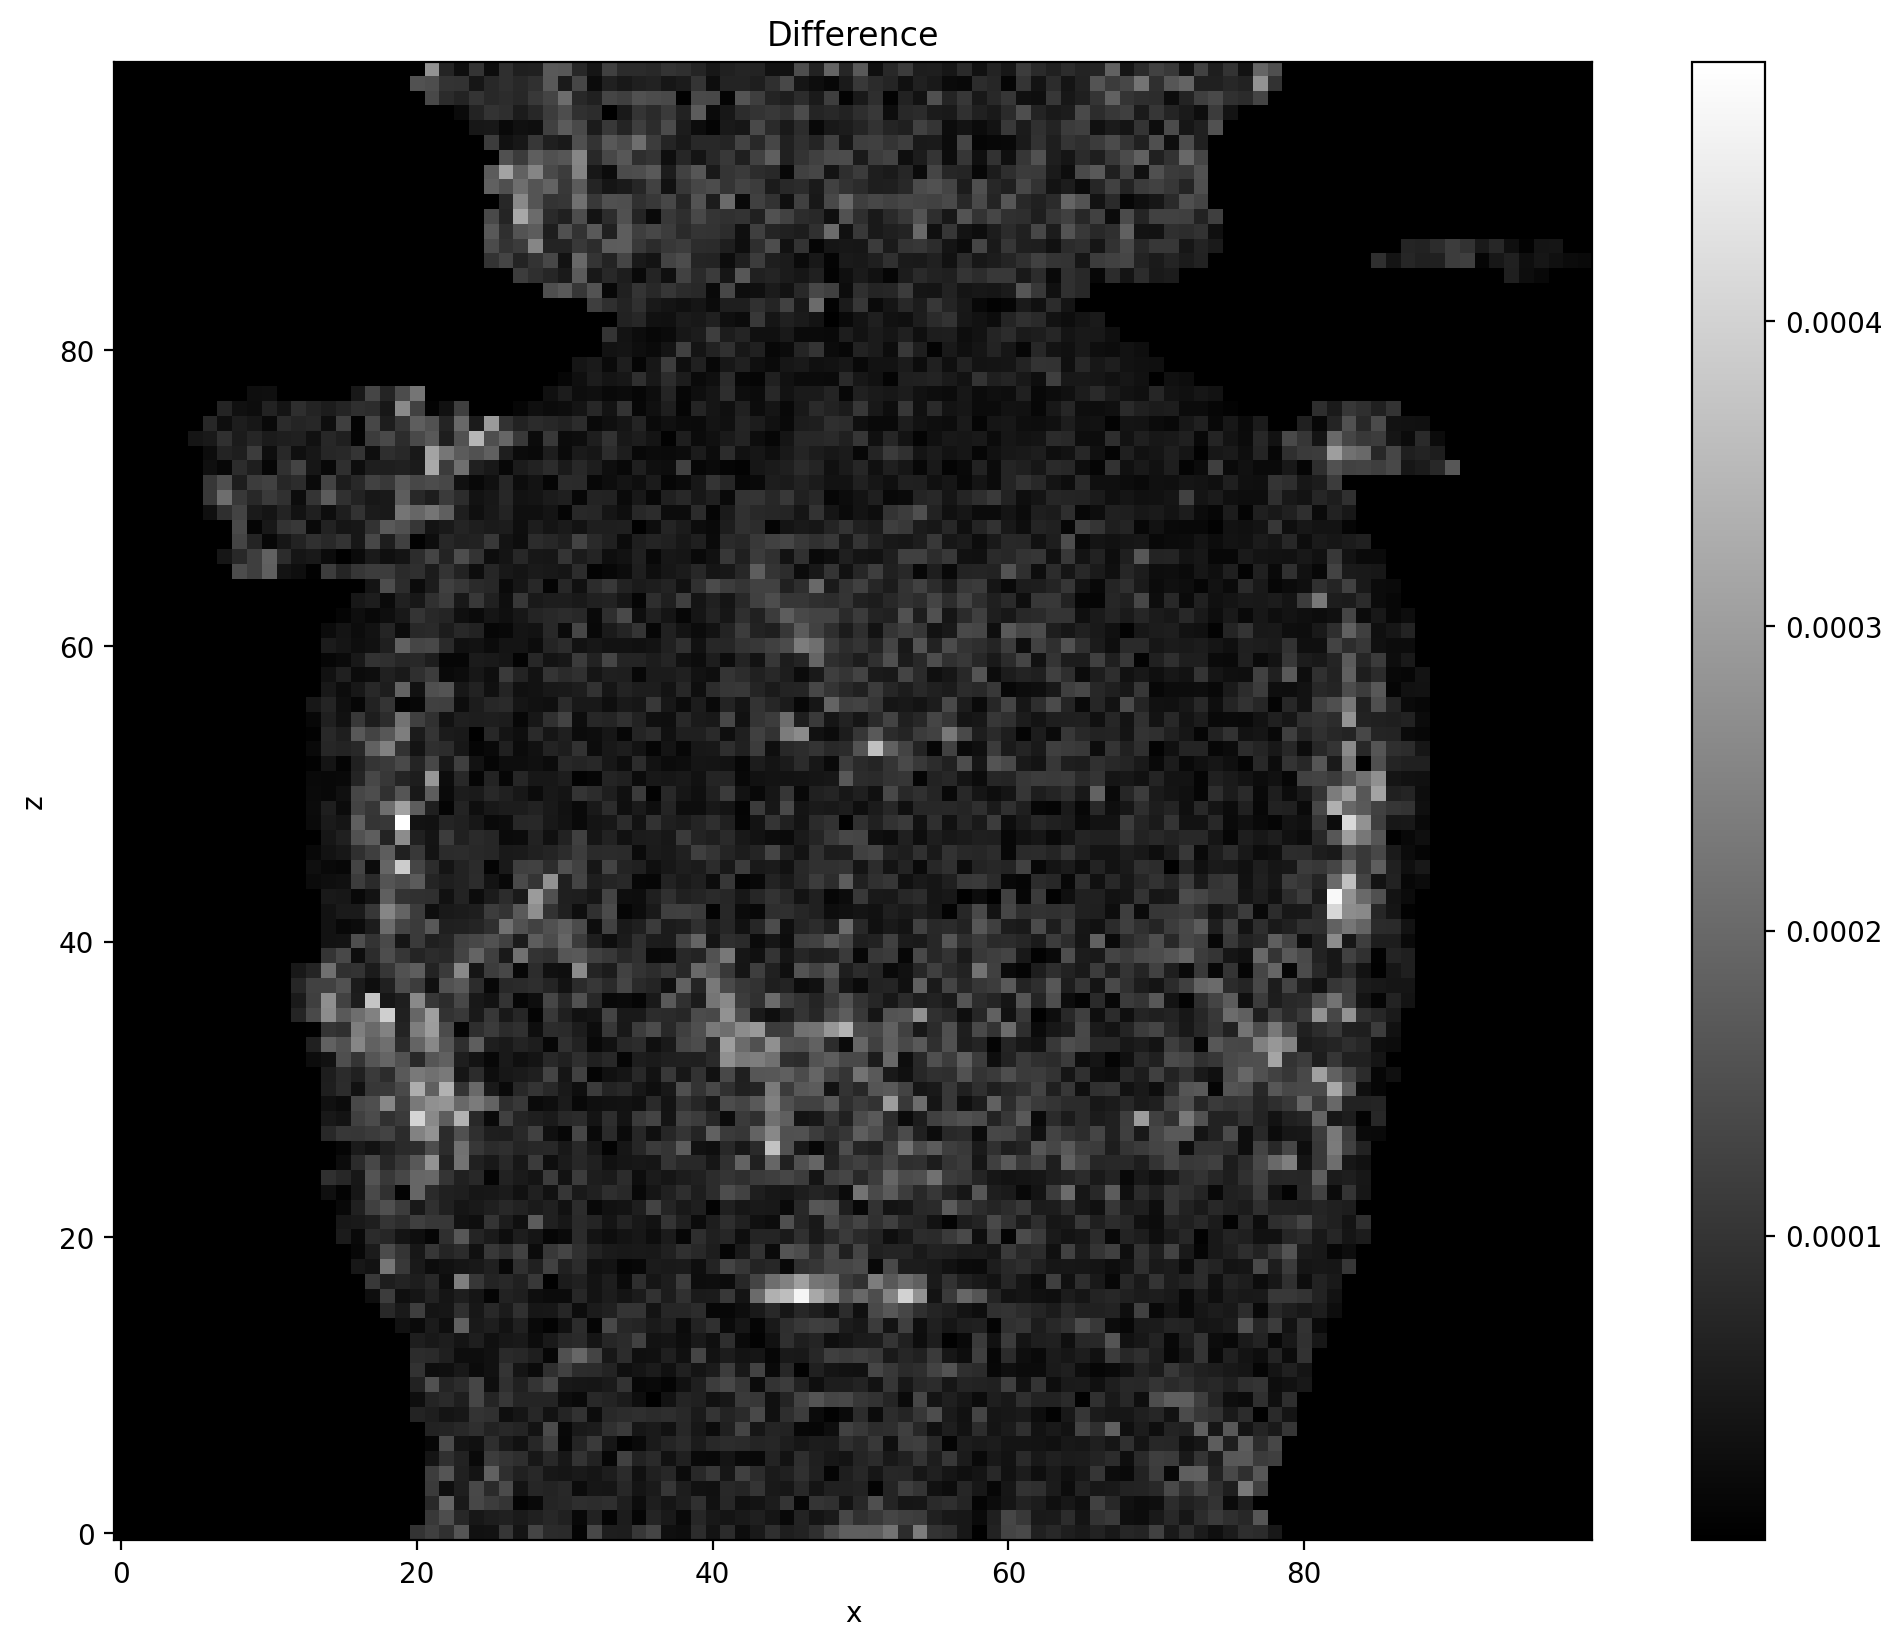

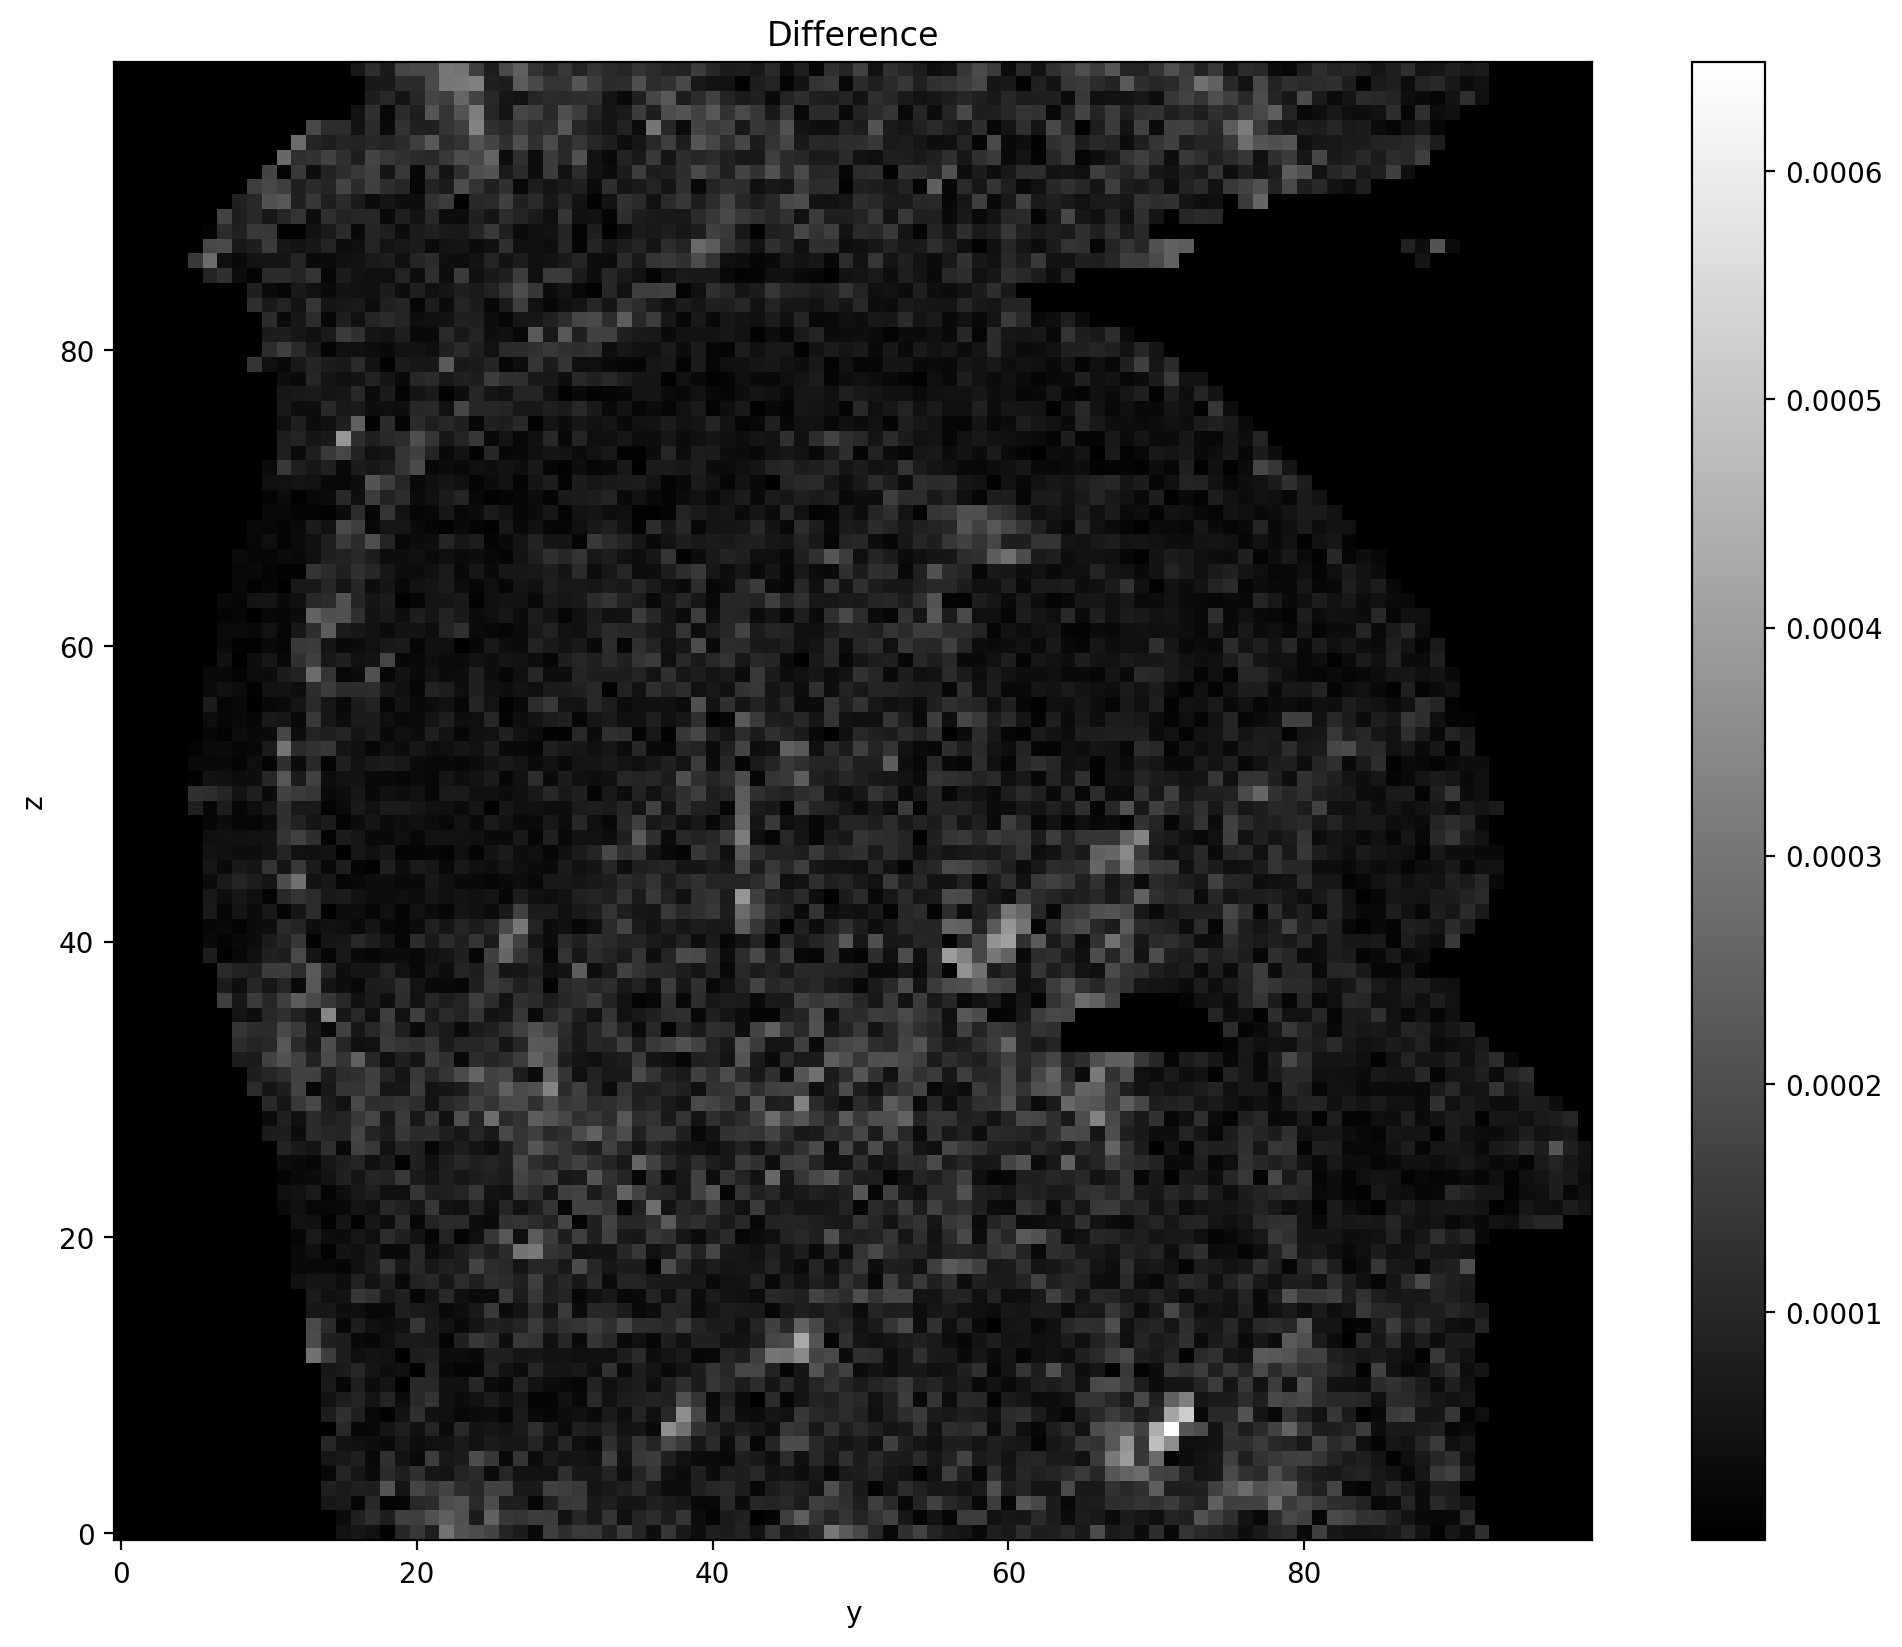

In [10]:
lamda = 0.01
start = time.time()
img_l1wav = mr.app.L1WaveletRecon(ksp_us, mps, lamda, device=gpu_id).run().get()
end = time.time()
print(f'Time elapsed: {end - start}')
img_l1wav /= np.linalg.norm(img_l1wav)

if dataType == '2D':
    plt.figure()
    plt.imshow(np.abs(img_l1wav), cmap='gray', origin='lower')
    plt.title('L1-wavelet regularized recon')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()

    plt.figure()
    plt.imshow(np.abs(img_l1wav - img_gt), cmap='gray', origin='lower')
    plt.title('Difference')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()

elif dataType == '3D':
    mid3views(np.abs(img_l1wav), 'L1-wavelet regularized recon')
    mid3views(np.abs(img_l1wav - img_gt), 'Difference')

# 3D times:
# Quickstep CPU: 12 m 3 s
# Quickstep GPU: 34 s

# Total Variation Recon

And we can do total variation regularized reconstruction with [TotalVariationRecon](https://sigpy.readthedocs.io/en/latest/generated/sigpy.mri.app.TotalVariationRecon.html#sigpy.mri.app.TotalVariationRecon).

In [11]:
lamda = 1e-5
start = time.time()
img_tv = mr.app.TotalVariationRecon(ksp_us, mps, lamda, device=gpu_id).run().get()
end = time.time()
print(f'Time elapsed: {end - start}')
img_tv /= np.linalg.norm(img_tv)

if dataType == '2D':
    plt.figure()
    plt.imshow(np.abs(img_tv), cmap='gray', origin='lower')
    plt.title('Total variation regularized recon')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()

    plt.figure()
    plt.imshow(np.abs(img_tv - img_gt), cmap='gray', origin='lower')
    plt.title('Difference')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()

elif dataType == '3D':
    mid3views(np.abs(img_tv), 'Total variation regularized recon')
    mid3views(np.abs(img_tv - img_gt), 'Difference')

# 3D times:
# Quickstep CPU: 14 m 48 s
# Quickstep GPU: 23 s

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

TotalVariationRecon:   0%|          | 0/100 [00:00<?, ?it/s]

ValueError: The device where the array resides (3) is different from the current device (0). Peer access is unavailable between these devices.